In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Introduction

Data engineering and preparation can support various machine learning algorithm for classification. The Titanic datasets contains the records of the Titanic passengers during its maiden voyage and tragic demise.  

This notebook has twofold. Firstly, we explore how various data preparation for various classifier may help predicting survivors from the titanic dataset. Secondly, we identify the characteristics contributing to accurate prediction. 




# Table of content

- __[Upload libraires](#Libraries)__
- __[Data engineering](#Data-engineering)__
    - [Import and explore the data](#Import-and-explore-the-data) 
        - [Training dataset](#Training-dataset)
        - [Test dataset](#Test-dataset)
    - [Meta data](#Meta-data) 
    - [Survival characteristics](#Survival-characteristics)
- __[Data preparation for classification](#Data-preparation-for-classification)__ 

    - [Data transformation](#Data-transformation) 
    - [PClass and Fare](#PClass-and-Fare) 
    - [Age](#Age)
    - [Embarked](#Embarked)
    - [Gender](#Gender) 
    - [Siblings and parentage](#Sibling-and-parentage)
    - [Columns to drop](#Columns-to-drop) 
- __[Decision Trees and Random Forrest](#Decision-Trees-and-Random-Forrest)__
    
    - [Preparation Cross validation](#Preparation-Cross-validation) 
    - [Decision Tree classifier](#Decision-Tree-classifier)
- __[Logistic regression](#Logistic-regression)__

# Libraries

In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sb
import os
import random as rand
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__)



Tensorflow version:  2.6.4


# Data engineering

We explore the files in the folder, sets the paths and file names. These variables will be used in each section.

In [4]:
!ls ../input/titanic/


gender_submission.csv  test.csv  train.csv


In [5]:
train_data_path = '../input/titanic/train.csv'
test_data_path = '../input/titanic/test.csv'

## Import and explore the data 
Explore and import the training and test dataset provided by the competition.

### Training dataset

In [6]:
titanic_train = pd.read_csv(train_data_path)
titanic_train.dtypes



PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Test dataset

In [9]:
titanic_test = pd.read_csv(test_data_path)
titanic_test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [10]:
titanic_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [11]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


 ## Meta data 
 
| Column name | Description|
|---|---|
|Passenger_id| unique row indentifier |
|PClass | Categorical data (1 = 1st; 2 = 2nd; 3 = 3rd)|
| Survival | Categoricial data (0 = No; 1 = Yes) |
| Name | Characters  - Name of passenger  |
| Sex  | Categorical data male or female |
| Age  | integer values representing age |
| SigSp | integer Number of Siblings/Spouses Aboard |
| Parch | Number of Parents/Children Aboard |
| Ticket | Ticket number |
| Fare | Fare in GBP at time of travel|
| Cabin | Cabin |
| Embark | Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)|


Source - http://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf (7/12/2022)

## Survival characteristics
We explore the survival characteristics using several combinations of columns.

1. Pclass, Fare, and Survived
2. Embarked, and Survived
3. Embarked, Pclass and Survived
2. Gender and Survived
3. Gendre, Pclass and Survived
4. SibSp and Survived
5. Parch and Survived

In [12]:
temp =  titanic_train.groupby(["Survived"]).count()["PassengerId"]
temp                                                   

Survived
0    549
1    342
Name: PassengerId, dtype: int64

In [13]:
temp =  titanic_train.groupby(["Pclass","Fare","Survived"]).count()["PassengerId"]
temp.groupby(level=1).apply(lambda x:  x / float(x.sum()))       

Pclass  Fare     Survived
1       0.0000   0           0.333333
        5.0000   0           1.000000
        25.5875  0           1.000000
        25.9250  0           1.000000
        25.9292  1           1.000000
                               ...   
3       39.6875  0           1.000000
        46.9000  0           1.000000
        56.4958  0           0.285714
                 1           0.714286
        69.5500  0           1.000000
Name: PassengerId, Length: 336, dtype: float64

In [14]:
temp =  titanic_train.groupby(["Embarked","Survived"]).count()["PassengerId"]
temp.groupby(level=0).apply(lambda x:  x / float(x.sum()))                                                          

Embarked  Survived
C         0           0.446429
          1           0.553571
Q         0           0.610390
          1           0.389610
S         0           0.663043
          1           0.336957
Name: PassengerId, dtype: float64

In [15]:
temp =  titanic_train.groupby(["Embarked","Pclass","Survived"]).count()["PassengerId"]
temp.groupby(level=0).apply(lambda x:  x / float(x.sum()))                                                          

Embarked  Pclass  Survived
C         1       0           0.154762
                  1           0.351190
          2       0           0.047619
                  1           0.053571
          3       0           0.244048
                  1           0.148810
Q         1       0           0.012987
                  1           0.012987
          2       0           0.012987
                  1           0.025974
          3       0           0.584416
                  1           0.350649
S         1       0           0.082298
                  1           0.114907
          2       0           0.136646
                  1           0.118012
          3       0           0.444099
                  1           0.104037
Name: PassengerId, dtype: float64

In [16]:
temp =  titanic_train.groupby(["Sex","Survived"]).count()["PassengerId"]
temp.groupby(level=1).apply(lambda x:  x / float(x.sum()))                                                          

Sex     Survived
female  0           0.147541
        1           0.681287
male    0           0.852459
        1           0.318713
Name: PassengerId, dtype: float64

In [17]:
temp =  titanic_train.groupby(["Sex","Survived"]).count()["PassengerId"]
temp.groupby(level=1).apply(lambda x:  x / float(x.sum()))                                                          

Sex     Survived
female  0           0.147541
        1           0.681287
male    0           0.852459
        1           0.318713
Name: PassengerId, dtype: float64

In [18]:
temp =  titanic_train.groupby(["SibSp","Survived"]).count()["PassengerId"]
temp.groupby(level=0).apply(lambda x:  x / float(x.sum()))                                                          

SibSp  Survived
0      0           0.654605
       1           0.345395
1      0           0.464115
       1           0.535885
2      0           0.535714
       1           0.464286
3      0           0.750000
       1           0.250000
4      0           0.833333
       1           0.166667
5      0           1.000000
8      0           1.000000
Name: PassengerId, dtype: float64

In [19]:
temp =  titanic_train.groupby(["Parch","Survived"]).count()["PassengerId"]
temp.groupby(level=0).apply(lambda x:  x / float(x.sum()))                                                          

Parch  Survived
0      0           0.656342
       1           0.343658
1      0           0.449153
       1           0.550847
2      0           0.500000
       1           0.500000
3      0           0.400000
       1           0.600000
4      0           1.000000
5      0           0.800000
       1           0.200000
6      0           1.000000
Name: PassengerId, dtype: float64

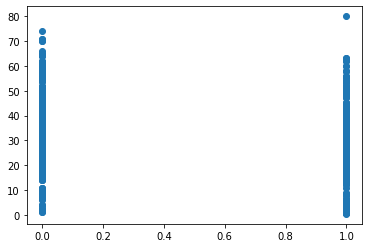

In [20]:
plt.scatter(titanic_train.Survived, titanic_train.Age)

The percentages suggests passenger class and gender may be the factor that may lead to survival. 

# Data preparation for classification

We upload the data for a cleaning and display the columns with their data types.

In [21]:
titanic_train = pd.read_csv(train_data_path)
titanic_train.dtypes



PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [22]:
titanic_test = pd.read_csv(test_data_path)
titanic_test.dtypes



PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Data transformation
We transform some of the integer columns into float, for future predictions.

In [23]:
titanic_train["PassengerId"] = titanic_train["PassengerId"].astype(float)
titanic_train["SibSp"] = titanic_train["SibSp"].astype(float)
titanic_train["Parch"] = titanic_train["Parch"].astype(float)
titanic_train["Survived"] = titanic_train["Survived"].astype(float)
titanic_train["Pclass"] = titanic_train["Pclass"].astype(float)
titanic_train.dtypes

PassengerId    float64
Survived       float64
Pclass         float64
Name            object
Sex             object
Age            float64
SibSp          float64
Parch          float64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [24]:
titanic_test["PassengerId"] = titanic_test["PassengerId"].astype(float)
titanic_test["SibSp"] = titanic_test["SibSp"].astype(float)
titanic_test["Parch"] = titanic_test["Parch"].astype(float)
titanic_test["Pclass"] = titanic_test["Pclass"].astype(float)
titanic_test.dtypes

PassengerId    float64
Pclass         float64
Name            object
Sex             object
Age            float64
SibSp          float64
Parch          float64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

We remove all the nulls values from some of the columns; i.e., PassengerId, Fare, SibSp, Parch, and Embarked.

In [25]:
titanic_train.PassengerId.isnull().sum()


0

In [26]:
titanic_test.PassengerId.isnull().sum()


0

In [27]:
titanic_train.Fare.isnull().sum()


0

In [28]:
titanic_test.Fare.isnull().sum()

1

In [29]:
titanic_test.loc[titanic_test["Fare"].isnull(),"Fare"] = -1.0
titanic_test.Fare.isnull().sum()

0

In [30]:
titanic_train.Age.isnull().sum()

177

In [31]:
titanic_train.loc[titanic_train["Age"].isnull(),"Age"] = -1.0
titanic_train.Age.isnull().sum()

0

In [32]:
titanic_test.loc[titanic_test["Age"].isnull(),"Age"] = -1.0
titanic_test.Age.isnull().sum()

0

We remove any NAs from the embarked column

In [33]:
print("Training : " , titanic_train.Embarked.unique())
print("Testing  : " , titanic_test.Embarked.unique())

Training :  ['S' 'C' 'Q' nan]
Testing  :  ['Q' 'S' 'C']


In [34]:
titanic_train.loc[titanic_train['Embarked'].isna(),'Embarked'] = 'U'

In [35]:
titanic_test.loc[titanic_test['Embarked'].isna(),'Embarked'] = 'U'


In [36]:
print("Training : " , titanic_train.Embarked.unique())
print("Testing  : " , titanic_test.Embarked.unique())

Training :  ['S' 'C' 'Q' 'U']
Testing  :  ['Q' 'S' 'C']


In [37]:
print("Training : " , titanic_train.Sex.unique())
print("Testing  : " , titanic_test.Sex.unique())

Training :  ['male' 'female']
Testing  :  ['male' 'female']


In [38]:
print("Training : " , titanic_train.Pclass.unique())
print("Testing  : " , titanic_test.Pclass.unique())

Training :  [3. 1. 2.]
Testing  :  [3. 2. 1.]


## PClass and Fare

We explore first if there is correalation between the passenger class and prices. We also explore the skewness of the fares. So we normalise the fare to move more the values towards the mean. We hope it will help the decision trees and random forrest classification.

In [39]:
temp =  titanic_train.groupby(["Pclass","Fare","Survived"]).count()["PassengerId"]
temp = temp.groupby(level=1).apply(lambda x:100 * x / float(x.sum()))                               
temp

Pclass  Fare     Survived
1.0     0.0000   0.0          33.333333
        5.0000   0.0         100.000000
        25.5875  0.0         100.000000
        25.9250  0.0         100.000000
        25.9292  1.0         100.000000
                                ...    
3.0     39.6875  0.0         100.000000
        46.9000  0.0         100.000000
        56.4958  0.0          28.571429
                 1.0          71.428571
        69.5500  0.0         100.000000
Name: PassengerId, Length: 336, dtype: float64

(array([ 15.,   2.,  80., 240.,  48.,  81.,  33.,  20.,  24.,  19.,  77.,
         27.,  19.,  12.,   4.,  15.,   4.,   0.,   7.,   5.,  18.,   5.,
         13.,   3.,   2.,   4.,   0.,  12.,   5.,   5.,  13.,   6.,   7.,
          3.,   2.,   6.,   2.,   0.,   0.,   0.,   0.,   2.,   2.,   4.,
          3.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,   7.,   0.,   0.,
          0.,   0.,   2.,   0.,   7.,   0.,   0.,   0.,   0.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,   1.,   0.,
          4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,
          0.,   0.,   0.,   6.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

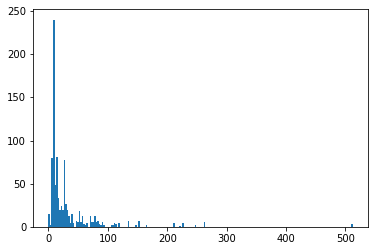

In [40]:
plt.hist(titanic_train.Fare, bins=200)

<AxesSubplot:title={'center':'Fare'}, xlabel='Pclass'>

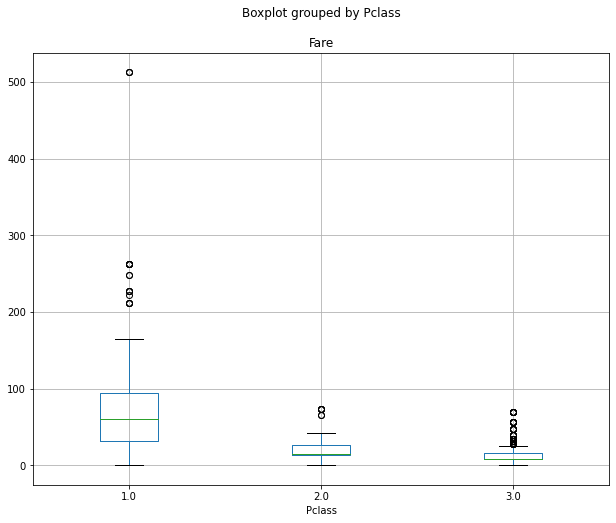

In [41]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
titanic_train.boxplot(column=['Fare'], by='Pclass', ax=ax)

In [42]:
titanic_train.groupby("Pclass").describe()["Fare"]

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1.0,216.0,84.154687,78.380373,0.0,30.92395,60.2875,93.5,512.3292
2.0,184.0,20.662183,13.417399,0.0,13.00000,14.2500,26.0,73.5000
3.0,491.0,13.675550,11.778142,0.0,7.75000,8.0500,15.5,69.5500


/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


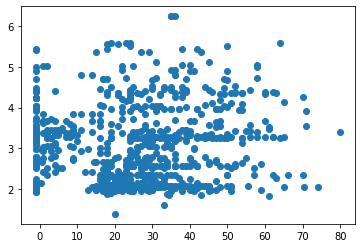

In [43]:
plt.scatter(titanic_train.Age,np.log(titanic_train.Fare))
    

In [44]:
mean_fare = titanic_train.Fare.mean()
std_fare = titanic_train.Fare.std()
titanic_train.loc[:,"Fare"] = (titanic_train.Fare - mean_fare)/std_fare
titanic_train.Fare.describe()


count    8.910000e+02
mean    -1.196200e-17
std      1.000000e+00
min     -6.480577e-01
25%     -4.888737e-01
50%     -3.571902e-01
75%     -2.423274e-02
max      9.661740e+00
Name: Fare, dtype: float64

(array([ 17., 320., 129.,  53.,  43., 104.,  31.,  19.,   4.,  12.,  23.,
         16.,   6.,  12.,  10.,  19.,  10.,   8.,   2.,   0.,   2.,   6.,
          3.,   4.,   0.,   0.,   7.,   0.,   2.,   7.,   0.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,   1.,
          4.,   0.,   0.,   0.,   2.,   0.,   0.,   6.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          3.]),
 array([-0.64805768, -0.5449597 , -0.44186172, -0.33876374, -0.23566577,
        -0.13256779, -0.02946981,  0.07362817,  0.17672614,  0.27982412,
         0.3829221 ,  0.48602008,  0.58911806,  0.69221603,  0.79531401,
         0.89841199,  1.00150997,  1.10460794,  1.20770592,  1.3108039 ,
         1.41390188,  1.51

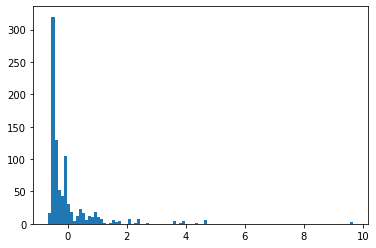

In [45]:
plt.hist(titanic_train.Fare, bins = 100)

In [46]:
mean_fare = titanic_test.Fare.mean()
std_fare = titanic_test.Fare.std()
titanic_test.loc[:,"Fare"] = (titanic_test.Fare - mean_fare)/std_fare
titanic_test.Fare.describe()


count    4.180000e+02
mean    -5.843279e-17
std      1.000000e+00
min     -6.540195e-01
25%     -4.947941e-01
50%     -3.774057e-01
75%     -7.280731e-02
max      8.534029e+00
Name: Fare, dtype: float64

(array([  4., 146.,  57.,  31.,  27.,  43.,  13.,   9.,   3.,   5.,  10.,
          8.,   7.,   4.,   6.,   4.,   7.,   1.,   2.,   0.,   1.,   1.,
          0.,   0.,   0.,   0.,   6.,   0.,   1.,   2.,   0.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,   3.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   7.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-0.65401945, -0.56213897, -0.47025848, -0.378378  , -0.28649751,
        -0.19461703, -0.10273654, -0.01085606,  0.08102443,  0.17290491,
         0.2647854 ,  0.35666588,  0.44854636,  0.54042685,  0.63230733,
         0.72418782,  0.8160683 ,  0.90794879,  0.99982927,  1.09170976,
         1.18359024,  1.27

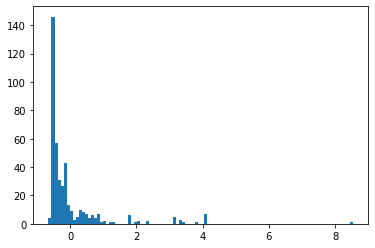

In [47]:
plt.hist(titanic_test.Fare, bins = 100)

In [48]:
titanic_train.dtypes

PassengerId    float64
Survived       float64
Pclass         float64
Name            object
Sex             object
Age            float64
SibSp          float64
Parch          float64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Age
We normalise the age to bring more the data towards the mean.

(array([177.,   1.,  13.,  10.,   6.,   0.,  10.,   4.,   3.,   3.,   0.,
          4.,   8.,   2.,   4.,   0.,   1.,   2.,   6.,   6.,  17.,   0.,
         13.,  26.,  25.,  15.,   1.,  24.,  27.,  15.,  31.,   1.,  23.,
         18.,  18.,  25.,   2.,  20.,  27.,  17.,  18.,  17.,   0.,  16.,
         18.,  22.,   7.,   0.,  11.,  14.,  13.,   8.,   0.,  13.,   5.,
          9.,  12.,   2.,   3.,   9.,   9.,   6.,  10.,   0.,   7.,   6.,
          1.,   8.,   0.,   3.,   4.,   2.,   5.,   0.,   2.,   4.,   3.,
          4.,   0.,   2.,   2.,   3.,   1.,   0.,   0.,   0.,   0.,   2.,
          3.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-1.  , -0.19,  0.62,  1.43,  2.24,  3.05,  3.86,  4.67,  5.48,
         6.29,  7.1 ,  7.91,  8.72,  9.53, 10.34, 11.15, 11.96, 12.77,
        13.58, 14.39, 15.2 , 16.01, 16.82, 17.63, 18.44, 19.25, 20.06,
        20.87, 21.68, 22.49, 23.3 , 24.11, 24.92, 25.73, 26.54, 27.35,
        28.16, 28.97, 29.78, 30.59

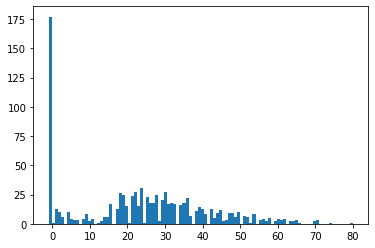

In [49]:
plt.hist(titanic_train.Age, bins = 100)

In [50]:
mean_age = titanic_train.Age.mean()
std_age = titanic_train.Age.std()
titanic_train.loc[:,"Age"] = (titanic_train.Age - mean_age)/std_age
titanic_train.Age.describe()


count    8.910000e+02
mean     1.634807e-16
std      1.000000e+00
min     -1.376838e+00
25%     -9.850647e-01
50%      2.235122e-02
75%      6.379943e-01
max      3.156534e+00
Name: Age, dtype: float64

(array([177.,   1.,  13.,  10.,   6.,   0.,  10.,   4.,   3.,   3.,   0.,
          4.,   8.,   2.,   4.,   0.,   1.,   2.,   6.,   6.,  17.,   0.,
         13.,  26.,  25.,  15.,   1.,  24.,  27.,  15.,  31.,   1.,  23.,
         18.,  18.,  25.,   2.,  20.,  27.,  17.,  18.,  17.,   0.,  16.,
         18.,  22.,   7.,   0.,  11.,  14.,  13.,   8.,   0.,  13.,   5.,
          9.,  12.,   2.,   3.,   9.,   9.,   6.,  10.,   0.,   7.,   6.,
          1.,   8.,   0.,   3.,   4.,   2.,   5.,   0.,   2.,   4.,   3.,
          4.,   0.,   2.,   2.,   3.,   1.,   0.,   0.,   0.,   0.,   2.,
          3.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-1.37683754, -1.33150382, -1.28617011, -1.24083639, -1.19550268,
        -1.15016896, -1.10483524, -1.05950153, -1.01416781, -0.9688341 ,
        -0.92350038, -0.87816667, -0.83283295, -0.78749923, -0.74216552,
        -0.6968318 , -0.65149809, -0.60616437, -0.56083066, -0.51549694,
        -0.47016323, -0.42

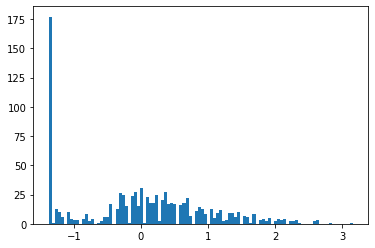

In [51]:
plt.hist(titanic_train.Age, bins = 100)

In [52]:
mean_age = titanic_test.Age.mean()
std_age = titanic_test.Age.std()
titanic_test.loc[:,"Age"] = (titanic_test.Age - mean_age)/std_age
titanic_train.Age.describe()

count    8.910000e+02
mean     1.634807e-16
std      1.000000e+00
min     -1.376838e+00
25%     -9.850647e-01
50%      2.235122e-02
75%      6.379943e-01
max      3.156534e+00
Name: Age, dtype: float64

## Embarked

Embarked has three values "S", 'C', 'Q' and "U".  

In [53]:
titanic_train.groupby("Embarked").count()["PassengerId"]

Embarked
C    168
Q     77
S    644
U      2
Name: PassengerId, dtype: int64

In [54]:
titanic_test.groupby("Embarked").count()["PassengerId"]

Embarked
C    102
Q     46
S    270
Name: PassengerId, dtype: int64

In [55]:
titanic_train["Embarked"].replace({"U":0, "S":1, "C":2, "Q":3}, inplace = True)
titanic_train["Embarked"] = titanic_train["Embarked"].astype(float)
titanic_train.groupby("Embarked").count()["PassengerId"]



Embarked
0.0      2
1.0    644
2.0    168
3.0     77
Name: PassengerId, dtype: int64

In [56]:
titanic_test["Embarked"].replace({"U":0, "S":1, "C":2, "Q":3}, inplace = True)
titanic_test["Embarked"] = titanic_test["Embarked"].astype(float)
titanic_test.groupby("Embarked").count()["PassengerId"]

Embarked
1.0    270
2.0    102
3.0     46
Name: PassengerId, dtype: int64

## Gender 
We replace the male with 1 and female with the value 2.

In [57]:
print("Training : ", titanic_train['Sex'].unique())
print("Test     : ", titanic_train['Sex'].unique())



Training :  ['male' 'female']
Test     :  ['male' 'female']


In [58]:
titanic_train["Sex"].replace({"male":1.0, "female":2.0}, inplace = True)
titanic_train["Sex"] = titanic_train["Sex"].astype(float)
titanic_train.groupby("Sex").count()["PassengerId"]

Sex
1.0    577
2.0    314
Name: PassengerId, dtype: int64

In [59]:
titanic_test["Sex"].replace({"male":1.0, "female":2.0}, inplace = True)
titanic_test["Sex"] = titanic_test["Sex"].astype(float)
titanic_test.groupby("Sex").count()["PassengerId"]


Sex
1.0    266
2.0    152
Name: PassengerId, dtype: int64

## Sibling and parentage

We sum the siblin and parentage. 

In [60]:
titanic_train["fam_members"] = titanic_train["SibSp"] + titanic_train["Parch"]
titanic_train["fam_members"].describe()

count    891.000000
mean       0.904602
std        1.613459
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       10.000000
Name: fam_members, dtype: float64

In [61]:
titanic_test["fam_members"] = titanic_test["SibSp"] + titanic_test["Parch"]
titanic_test["fam_members"].describe()

count    418.000000
mean       0.839713
std        1.519072
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       10.000000
Name: fam_members, dtype: float64

In [62]:
titanic_test["fam_members"] = titanic_test["SibSp"] + titanic_test["Parch"]
titanic_test["fam_members"].describe()

count    418.000000
mean       0.839713
std        1.519072
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       10.000000
Name: fam_members, dtype: float64

In [63]:
titanic_train.dtypes

PassengerId    float64
Survived       float64
Pclass         float64
Name            object
Sex            float64
Age            float64
SibSp          float64
Parch          float64
Ticket          object
Fare           float64
Cabin           object
Embarked       float64
fam_members    float64
dtype: object

In [64]:
titanic_test.dtypes

PassengerId    float64
Pclass         float64
Name            object
Sex            float64
Age            float64
SibSp          float64
Parch          float64
Ticket          object
Fare           float64
Cabin           object
Embarked       float64
fam_members    float64
dtype: object

## Columns to drop 
We drop some columns; they may have too many unknown values. Some of them may be dependent statistical variables. We assume the price of a ticket may be dependent of the fare.  

In [65]:
titanic_train.drop("Name", axis = 1, inplace = True)
titanic_train.drop("Ticket", axis = 1, inplace = True)
titanic_train.drop("Cabin", axis = 1, inplace = True)
titanic_train.drop("SibSp", axis = 1, inplace = True)
titanic_train.drop("Parch", axis = 1, inplace = True)

titanic_train.dtypes

PassengerId    float64
Survived       float64
Pclass         float64
Sex            float64
Age            float64
Fare           float64
Embarked       float64
fam_members    float64
dtype: object

In [66]:
titanic_test.drop("Name", axis = 1, inplace = True)
titanic_test.drop("Ticket", axis = 1, inplace = True)
titanic_test.drop("Cabin", axis = 1, inplace = True)
titanic_test.drop("SibSp", axis = 1, inplace = True)
titanic_test.drop("Parch", axis = 1, inplace = True)

titanic_test.dtypes

PassengerId    float64
Pclass         float64
Sex            float64
Age            float64
Fare           float64
Embarked       float64
fam_members    float64
dtype: object

## Preparation Cross validation 
We show how the transformation have affected both datasets

In [67]:
titanic_train.dtypes

PassengerId    float64
Survived       float64
Pclass         float64
Sex            float64
Age            float64
Fare           float64
Embarked       float64
fam_members    float64
dtype: object

In [68]:
titanic_train.shape

(891, 8)

In [69]:
titanic_test.dtypes

PassengerId    float64
Pclass         float64
Sex            float64
Age            float64
Fare           float64
Embarked       float64
fam_members    float64
dtype: object

In [70]:
titanic_test.shape

(418, 7)

# Decision Trees and Random Forrest


## Preparation Cross validation 

We split the training datasets into a training and valication dataset. We use stratified shuffle for this purpose. 

In [71]:
x_cols = ["Fare","Pclass","Sex","Embarked","fam_members", "Age"]
y_col = 'Survived'
X = titanic_train.copy(deep = True)
X = X[x_cols]
#X = X.apply(pd.to_numeric)
y = titanic_train[y_col].apply(pd.to_numeric)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid  = X.iloc[test_valid_index]
    y_valid  = y.iloc[test_valid_index]

# we see our training set follows the same distribution
print(y_train.value_counts(normalize=True), '\n\n')

# we see our test set follows the same distribution
print(y_valid.value_counts(normalize=True))

0.0    0.616105
1.0    0.383895
Name: Survived, dtype: float64 


0.0    0.616246
1.0    0.383754
Name: Survived, dtype: float64


In [72]:
x_cols = ["Fare","Pclass","Sex","Embarked","fam_members", "Age"]
X = titanic_test.copy(deep = True)
X_test = X[x_cols]
X_test.columns

Index(['Fare', 'Pclass', 'Sex', 'Embarked', 'fam_members', 'Age'], dtype='object')

## Decision Tree classifier

We explore the maximum depths hyper parameter using a deterministic and incremental search. Then we applied the most efficient parametrisation. We chose a low maximum depth, as the model may be overfitting.

In [73]:

depths = range(3, 200)
for depth in depths:
    clf = DecisionTreeClassifier(max_depth = depth, criterion ="entropy")

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)
    train_score = clf.score(X_train,y_train)
    valid_score = clf.score(X_valid,y_valid)
    print("- depth : ", depth, " - train score : ", train_score, " -  valid score : ", valid_score)
   


- depth :  3  - train score :  0.8108614232209738  -  valid score :  0.7983193277310925
- depth :  4  - train score :  0.8220973782771536  -  valid score :  0.7787114845938375
- depth :  5  - train score :  0.848314606741573  -  valid score :  0.8123249299719888
- depth :  6  - train score :  0.8689138576779026  -  valid score :  0.8067226890756303
- depth :  7  - train score :  0.897003745318352  -  valid score :  0.8067226890756303
- depth :  8  - train score :  0.9232209737827716  -  valid score :  0.8067226890756303
- depth :  9  - train score :  0.9307116104868914  -  valid score :  0.7927170868347339
- depth :  10  - train score :  0.9456928838951311  -  valid score :  0.7983193277310925
- depth :  11  - train score :  0.9588014981273408  -  valid score :  0.7815126050420168
- depth :  12  - train score :  0.9644194756554307  -  valid score :  0.7871148459383753
- depth :  13  - train score :  0.9719101123595506  -  valid score :  0.7955182072829131
- depth :  14  - train score :

In [74]:
clf = DecisionTreeClassifier(max_depth = 5, criterion ="gini")

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
train_score = clf.score(X_train,y_train)
valid_score = clf.score(X_valid,y_valid)
print("- depth : ", 5, " - train score : ", train_score, " -  valid score : ", valid_score)

- depth :  5  - train score :  0.8558052434456929  -  valid score :  0.8151260504201681


The next step is to explore the number of maximum features used.  We chose two. 

In [75]:
features = range(1, X_train.shape[1])
for max_feature in features:
    clf = DecisionTreeClassifier(max_depth = 5, criterion ="entropy", max_features = max_feature)
    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)
    train_score = clf.score(X_train,y_train)
    valid_score = clf.score(X_valid,y_valid)
    print("- max feature: ", max_feature, " - train score : ", train_score, " -  valid score : ", valid_score)
   

- max feature:  1  - train score :  0.7865168539325843  -  valid score :  0.7563025210084033
- max feature:  2  - train score :  0.8239700374531835  -  valid score :  0.8375350140056023
- max feature:  3  - train score :  0.8239700374531835  -  valid score :  0.7871148459383753
- max feature:  4  - train score :  0.8370786516853933  -  valid score :  0.7871148459383753
- max feature:  5  - train score :  0.848314606741573  -  valid score :  0.8263305322128851


In [76]:
clf = DecisionTreeClassifier(max_depth = 5, criterion ="gini", max_features = 2)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
train_score = clf.score(X_train,y_train)
valid_score = clf.score(X_valid,y_valid)
print("- depth : ", 5, " - train score : ", train_score, " -  valid score : ", valid_score)

- depth :  5  - train score :  0.8314606741573034  -  valid score :  0.7871148459383753


In [90]:
importances = clf.feature_importances_
importances =  pd.DataFrame(x_cols, importances)
importances

,0
0.094897,Fare
0.194584,Pclass
0.505656,Sex
0.052397,Embarked
0.087099,fam_members
0.065366,Age


Several runs of applying decision tree has suggested the gender, passenger class, age, Fare and number of familly numbers may influencd the most the classification. Therefore, we decided to reduce the dataset to the following columns; Sex, Pclass, fam_members, and Age. 

### Which passengers were misclassified 

In [78]:
y_pred  = clf.predict(X_valid)

In [91]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, y_pred)

array([[196,  24],
       [ 52,  85]])

Overall, the number of survivors misclassified were greater than misclassifiee  passengers who  perished. The next step is to identify those passengers to attempt to find the source of the misclassification.

In [80]:
errors_pd = X_valid.copy(deep=True)
errors_pd["Y_true"] = y_valid
errors_pd["Y_pred"] = y_pred
errors_pd = errors_pd.loc[errors_pd["Y_true"] !=  errors_pd["Y_pred"],]
errors_pd

,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
279,-0.240559,3.0,2.0,1.0,2.0,0.637994,1.0,0.0
607,-0.034294,1.0,1.0,1.0,0.0,0.190254,1.0,0.0
804,-0.507697,3.0,1.0,1.0,0.0,0.190254,1.0,0.0
429,-0.486064,3.0,1.0,1.0,0.0,0.470092,1.0,0.0
501,-0.492101,3.0,2.0,3.0,0.0,-0.145551,0.0,1.0
...,...,...,...,...,...,...,...,...
311,4.631815,1.0,2.0,2.0,4.0,-0.313454,1.0,0.0
23,0.066322,1.0,1.0,1.0,0.0,0.246221,1.0,0.0
49,-0.289861,3.0,2.0,1.0,1.0,-0.313454,0.0,1.0
455,-0.489167,3.0,1.0,2.0,0.0,0.302189,1.0,0.0


In [83]:
errors_pd.describe()

,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,0.338174,2.223684,1.342105,1.342105,1.368421,0.026770,0.684211,0.315789
std,1.642952,0.917950,0.477567,0.601168,2.051615,0.933647,0.467918,0.467918
min,-0.648058,1.000000,1.000000,1.000000,0.000000,-1.376838,0.000000,0.000000
25%,-0.486064,1.000000,1.000000,1.000000,0.000000,-0.425389,0.000000,0.000000
50%,-0.235025,3.000000,1.000000,1.000000,1.000000,0.078319,1.000000,0.000000
75%,0.415673,3.000000,2.000000,2.000000,2.000000,0.498075,1.000000,1.000000
max,9.661740,3.000000,2.000000,3.000000,10.000000,2.149118,1.000000,1.000000


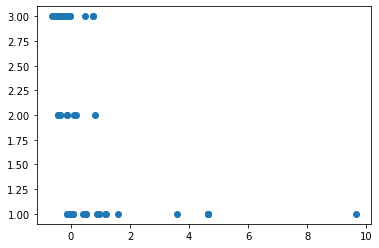

In [86]:
plt.scatter(errors_pd["Fare"], errors_pd["Pclass"])

In [87]:
errors_pd.loc[errors_pd["Pclass"] == 1.0]

,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
607,-0.034294,1.0,1.0,1.0,0.0,0.190254,1.0,0.0
341,4.644393,1.0,2.0,1.0,5.0,0.022351,1.0,0.0
647,0.066322,1.0,1.0,2.0,0.0,1.813313,1.0,0.0
681,0.895994,1.0,1.0,2.0,0.0,0.190254,1.0,0.0
55,0.066322,1.0,1.0,1.0,0.0,-1.376838,1.0,0.0
701,-0.119064,1.0,1.0,1.0,0.0,0.637994,1.0,0.0
698,1.583290,1.0,1.0,2.0,2.0,1.421540,0.0,1.0
11,-0.113782,1.0,2.0,1.0,0.0,1.925248,1.0,0.0
88,4.644393,1.0,2.0,1.0,5.0,-0.033616,1.0,0.0
377,3.608038,1.0,1.0,2.0,2.0,0.190254,0.0,1.0


In [89]:
errors_pd.loc[errors_pd["Pclass"] == 2.0]

,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
17,-0.386454,2.0,1.0,1.0,0.0,-1.376838,1.0,0.0
199,-0.386454,2.0,2.0,1.0,0.0,0.022351,0.0,1.0
637,-0.119819,2.0,1.0,1.0,2.0,0.414124,0.0,1.0
314,-0.119819,2.0,1.0,1.0,2.0,1.085735,0.0,1.0
655,0.831011,2.0,1.0,1.0,2.0,0.022351,0.0,1.0
570,-0.436762,2.0,1.0,1.0,0.0,2.149118,1.0,0.0
685,0.188657,2.0,1.0,2.0,3.0,0.078319,0.0,1.0
226,-0.436762,2.0,1.0,1.0,0.0,-0.257487,1.0,0.0
817,0.096592,2.0,1.0,2.0,2.0,0.414124,0.0,1.0


In [92]:
errors_pd.loc[errors_pd["Pclass"] == 3.0]

,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
804,6.9750,3.0,1.0,1.0,0.0,0.190254,1.0,0.0
429,8.0500,3.0,1.0,1.0,0.0,0.470092,1.0,0.0
826,56.4958,3.0,1.0,1.0,0.0,-1.376838,0.0,1.0
315,7.8542,3.0,2.0,1.0,0.0,0.134286,1.0,0.0
205,10.4625,3.0,2.0,1.0,1.0,-1.208935,0.0,1.0
106,7.6500,3.0,2.0,1.0,0.0,-0.145551,1.0,0.0
414,7.9250,3.0,1.0,1.0,0.0,1.141702,1.0,0.0
502,7.6292,3.0,2.0,3.0,0.0,-1.376838,0.0,1.0
7,21.0750,3.0,1.0,1.0,4.0,-1.208935,0.0,1.0
639,16.1000,3.0,1.0,1.0,1.0,-1.376838,0.0,1.0


The passenger class  and being  male can lead  to errors. However, the number of female passengers increases as the class lower.

## Classification using test datasets

In [92]:
y_pred = clf.predict(X_test)
decision_tree_pred = pd.DataFrame({"PassengerId": titanic_test.PassengerId,
                                   "Survived": y_pred})
decision_tree_pred

,PassengerId,Survived
0,892.0,0.0
1,893.0,0.0
2,894.0,0.0
3,895.0,0.0
4,896.0,0.0
...,...,...
413,1305.0,0.0
414,1306.0,1.0
415,1307.0,0.0
416,1308.0,0.0


## Decision Trees with reduced dataset

We explore whether a reduction of statistical variables may be beneficial to the classification. We have yet to find a better result. So Decision tree may have found its limit. 

In [129]:
x_cols = ["Pclass","Sex", "fam_members"]
y_col = 'Survived'
X = titanic_train.copy(deep = True)
X = X[x_cols]
#X = X.apply(pd.to_numeric)
y = titanic_train[y_col].apply(pd.to_numeric)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid  = X.iloc[test_valid_index]
    y_valid  = y.iloc[test_valid_index]

# we see our training set follows the same distribution
print(y_train.value_counts(normalize=True), '\n\n')

# we see our test set follows the same distribution
print(y_valid.value_counts(normalize=True))

0.0    0.616105
1.0    0.383895
Name: Survived, dtype: float64 


0.0    0.616246
1.0    0.383754
Name: Survived, dtype: float64


In [130]:
x_cols = ["Pclass","Sex", "fam_members"]
X = titanic_test.copy(deep = True)
X_test = X[x_cols]
X_test.columns

Index(['Pclass', 'Sex', 'fam_members'], dtype='object')

In [131]:

clf = DecisionTreeClassifier(max_depth = 5, criterion ="entropy", max_features = 3)
    # Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
train_score = clf.score(X_train,y_train)
valid_score = clf.score(X_valid,y_valid)
print("- depth : ", 5, "- max feature: ", 3, " - train score : ", train_score, " -  valid score : ", valid_score)
   

- depth :  5 - max feature:  3  - train score :  0.8239700374531835  -  valid score :  0.7787114845938375


### Which passengers were misclassified 

In [132]:
y_pred  = clf.predict(X_valid)

In [133]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, y_pred)

array([[191,  29],
       [ 50,  87]])

Overall, the number of survivors misclassified were greater than misclassifiee  passengers who  perished. The next step is to identify those passengers to attempt to find the source of the misclassification. The reduced statistical variables degraded the accuracy

In [134]:
errors_pd = X_valid.copy(deep=True)
errors_pd["Y_true"] = y_valid
errors_pd["Y_pred"] = y_pred
errors_pd = errors_pd.loc[errors_pd["Y_true"] !=  errors_pd["Y_pred"],]
errors_pd

,Pclass,Sex,fam_members,Y_true,Y_pred
534,3.0,2.0,0.0,0.0,1.0
607,1.0,1.0,0.0,1.0,0.0
804,3.0,1.0,0.0,1.0,0.0
429,3.0,1.0,0.0,1.0,0.0
501,3.0,2.0,0.0,0.0,1.0
...,...,...,...,...,...
455,3.0,1.0,0.0,1.0,0.0
39,3.0,2.0,1.0,1.0,0.0
347,3.0,2.0,1.0,1.0,0.0
148,2.0,1.0,2.0,0.0,1.0


In [135]:
errors_pd.describe()

,Pclass,Sex,fam_members,Y_true,Y_pred
count,79.000000,79.000000,79.000000,79.000000,79.000000
mean,2.253165,1.341772,1.113924,0.632911,0.367089
std,0.898265,0.477334,1.358613,0.485091,0.485091
min,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000
50%,3.000000,1.000000,1.000000,1.000000,0.000000
75%,3.000000,2.000000,2.000000,1.000000,1.000000
max,3.000000,2.000000,6.000000,1.000000,1.000000


In [138]:
errors_pd.loc[errors_pd["Pclass"] == 1.0]

,Pclass,Sex,fam_members,Y_true,Y_pred
607,1.0,1.0,0.0,1.0,0.0
647,1.0,1.0,0.0,1.0,0.0
438,1.0,1.0,5.0,0.0,1.0
681,1.0,1.0,0.0,1.0,0.0
55,1.0,1.0,0.0,1.0,0.0
701,1.0,1.0,0.0,1.0,0.0
698,1.0,1.0,2.0,0.0,1.0
745,1.0,1.0,2.0,0.0,1.0
377,1.0,1.0,2.0,0.0,1.0
435,1.0,2.0,3.0,1.0,0.0


In [139]:
errors_pd.loc[errors_pd["Pclass"] == 2.0]

,Pclass,Sex,fam_members,Y_true,Y_pred
17,2.0,1.0,0.0,1.0,0.0
199,2.0,2.0,0.0,0.0,1.0
637,2.0,1.0,2.0,0.0,1.0
314,2.0,1.0,2.0,0.0,1.0
655,2.0,1.0,2.0,0.0,1.0
684,2.0,1.0,2.0,0.0,1.0
570,2.0,1.0,0.0,1.0,0.0
685,2.0,1.0,3.0,0.0,1.0
226,2.0,1.0,0.0,1.0,0.0
817,2.0,1.0,2.0,0.0,1.0


In [140]:
errors_pd.loc[errors_pd["Pclass"] == 3.0]

,Pclass,Sex,fam_members,Y_true,Y_pred
534,3.0,2.0,0.0,0.0,1.0
804,3.0,1.0,0.0,1.0,0.0
429,3.0,1.0,0.0,1.0,0.0
501,3.0,2.0,0.0,0.0,1.0
419,3.0,2.0,2.0,0.0,1.0
415,3.0,2.0,0.0,0.0,1.0
414,3.0,1.0,0.0,1.0,0.0
142,3.0,2.0,1.0,1.0,0.0
502,3.0,2.0,0.0,0.0,1.0
165,3.0,1.0,2.0,1.0,0.0


The passenger class  and being  male can lead  to errors. However, the number of female passengers increases as the class lower.

In [141]:
y_pred = clf.predict(X_test)
decision_tree_red_dat_pred = pd.DataFrame({"PassengerId": titanic_test.PassengerId,
                                   "Survived": y_pred})
decision_tree_red_dat_pred

,PassengerId,Survived
0,892.0,0.0
1,893.0,0.0
2,894.0,0.0
3,895.0,0.0
4,896.0,1.0
...,...,...
413,1305.0,0.0
414,1306.0,1.0
415,1307.0,0.0
416,1308.0,0.0


# Random Forrest

## Preparation Cross validation 

We split the training datasets into a training and valication dataset. We use stratified shuffle for this purpose. 

In [142]:
x_cols = ["Fare","Pclass","Sex","Embarked","fam_members", "Age"]
y_col = 'Survived'
X = titanic_train.copy(deep = True)
X = X[x_cols]
#X = X.apply(pd.to_numeric)
y = titanic_train[y_col].apply(pd.to_numeric)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid  = X.iloc[test_valid_index]
    y_valid  = y.iloc[test_valid_index]

# we see our train
e_counts(normalize=True), '\n\n')

# we see our test set follows the same distribution
print(y_valid.value_counts(normalize=True))

0.0    0.616105
1.0    0.383895
Name: Survived, dtype: float64 


0.0    0.616246
1.0    0.383754
Name: Survived, dtype: float64


In [143]:
x_cols = ["Fare","Pclass","Sex","Embarked","fam_members", "Age"]
X = titanic_test.copy(deep = True)
X_test = X[x_cols]
X_test.columns

Index(['Fare', 'Pclass', 'Sex', 'Embarked', 'fam_members', 'Age'], dtype='object')

## Model fitting and classification

Random Forrest overfits to the training dataset. 

In [144]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = range(1,40)
max_depths   = range(1,10)

for est in n_estimators:
    for depth in max_depths:
        rf = RandomForestClassifier(n_estimators = est, max_depth = depth, random_state = 42)
        rf.fit(X_train, y_train)
        train_score = rf.score(X_train, y_train)
        test_score  = rf.score(X_valid, y_valid)
        print(" - estimators : ", est, 
              " - max depths : ", depth, 
              " - train score : ", train_score,
              " - valid score : ", valid_score)
        
        


 - estimators :  1  - max depths :  1  - train score :  0.6629213483146067  - valid score :  0.7787114845938375
 - estimators :  1  - max depths :  2  - train score :  0.704119850187266  - valid score :  0.7787114845938375
 - estimators :  1  - max depths :  3  - train score :  0.704119850187266  - valid score :  0.7787114845938375
 - estimators :  1  - max depths :  4  - train score :  0.7415730337078652  - valid score :  0.7787114845938375
 - estimators :  1  - max depths :  5  - train score :  0.7752808988764045  - valid score :  0.7787114845938375
 - estimators :  1  - max depths :  6  - train score :  0.795880149812734  - valid score :  0.7787114845938375
 - estimators :  1  - max depths :  7  - train score :  0.8295880149812734  - valid score :  0.7787114845938375
 - estimators :  1  - max depths :  8  - train score :  0.8651685393258427  - valid score :  0.7787114845938375
 - estimators :  1  - max depths :  9  - train score :  0.8782771535580525  - valid score :  0.778711484593

In [145]:
rf = RandomForestClassifier(n_estimators = 39, max_depth=9, random_state = 42)
rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=9, n_estimators=39, random_state=42)

In [146]:
rf.score(X_train, y_train)

0.951310861423221

In [147]:
rf.score(X_valid, y_valid)

0.8235294117647058

In [148]:
importances = rf.feature_importances_
importances =  pd.DataFrame(x_cols, importances)
importances


,0
0.285629,Fare
0.087675,Pclass
0.278439,Sex
0.040180,Embarked
0.096870,fam_members
0.211206,Age


We found the classes of importances are Fares, Sex, and Age.  

### Which passengers were misclassified 

In [149]:
y_pred  = rf.predict(X_valid)

In [150]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, y_pred)

array([[198,  22],
       [ 41,  96]])

Overall, the number of survivors misclassified were greater than misclassified  passengers who  perished. 

We explore further these erroneous predictions.

In [151]:
errors_pd = X_valid.copy(deep=True)
errors_pd["Y_true"] = y_valid
errors_pd["Y_pred"] = y_pred
errors_pd = errors_pd.loc[errors_pd["Y_true"] !=  errors_pd["Y_pred"],]
errors_pd

,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
534,-0.473739,3.0,2.0,1.0,0.0,0.358157,0.0,1.0
279,-0.240559,3.0,2.0,1.0,2.0,0.637994,1.0,0.0
607,-0.034294,1.0,1.0,1.0,0.0,0.190254,1.0,0.0
804,-0.507697,3.0,1.0,1.0,0.0,0.190254,1.0,0.0
381,-0.331281,3.0,2.0,2.0,2.0,-1.264902,1.0,0.0
...,...,...,...,...,...,...,...,...
455,-0.489167,3.0,1.0,2.0,0.0,0.302189,1.0,0.0
347,-0.324071,3.0,2.0,1.0,1.0,-1.376838,1.0,0.0
731,-0.269990,3.0,1.0,2.0,0.0,-0.705227,0.0,1.0
297,2.401641,1.0,2.0,1.0,3.0,-1.208935,0.0,1.0


In [152]:
errors_pd.describe()

,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,0.163792,2.269841,1.349206,1.444444,0.984127,0.066770,0.650794,0.349206
std,1.480404,0.936816,0.480548,0.690436,1.349935,1.048222,0.480548,0.480548
min,-0.648058,1.000000,1.000000,1.000000,0.000000,-1.376838,0.000000,0.000000
25%,-0.486064,1.000000,1.000000,1.000000,0.000000,-0.761194,0.000000,0.000000
50%,-0.324071,3.000000,1.000000,1.000000,1.000000,0.078319,1.000000,0.000000
75%,0.066322,3.000000,2.000000,2.000000,2.000000,0.665978,1.000000,1.000000
max,9.661740,3.000000,2.000000,3.000000,6.000000,2.596859,1.000000,1.000000


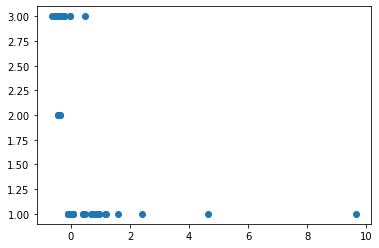

In [153]:
plt.scatter(errors_pd["Fare"], errors_pd["Pclass"])

In [154]:
errors_pd.loc[errors_pd["Pclass"] == 1.0]

,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
607,-0.034294,1.0,1.0,1.0,0.0,0.190254,1.0,0.0
647,0.066322,1.0,1.0,2.0,0.0,1.813313,1.0,0.0
438,4.644393,1.0,1.0,1.0,5.0,2.261053,0.0,1.0
681,0.895994,1.0,1.0,2.0,0.0,0.190254,1.0,0.0
55,0.066322,1.0,1.0,1.0,0.0,-1.376838,1.0,0.0
137,0.420494,1.0,1.0,1.0,1.0,0.749929,0.0,1.0
452,-0.089634,1.0,1.0,2.0,0.0,0.358157,0.0,1.0
698,1.583290,1.0,1.0,2.0,2.0,1.421540,0.0,1.0
745,0.780703,1.0,1.0,1.0,2.0,2.596859,0.0,1.0
430,-0.113782,1.0,1.0,1.0,0.0,0.246221,1.0,0.0


In [155]:
errors_pd.loc[errors_pd["Pclass"] == 2.0]

,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
17,-0.386454,2.0,1.0,1.0,0.0,-1.376838,1.0,0.0
199,-0.386454,2.0,2.0,1.0,0.0,0.022351,0.0,1.0
570,-0.436762,2.0,1.0,1.0,0.0,2.149118,1.0,0.0
226,-0.436762,2.0,1.0,1.0,0.0,-0.257487,1.0,0.0


In [156]:
errors_pd.loc[errors_pd["Pclass"] == 3.0]

,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
534,-0.473739,3.0,2.0,1.0,0.0,0.358157,0.0,1.0
279,-0.240559,3.0,2.0,1.0,2.0,0.637994,1.0,0.0
804,-0.507697,3.0,1.0,1.0,0.0,0.190254,1.0,0.0
381,-0.331281,3.0,2.0,2.0,2.0,-1.264902,1.0,0.0
429,-0.486064,3.0,1.0,1.0,0.0,0.470092,1.0,0.0
501,-0.492101,3.0,2.0,3.0,0.0,-0.145551,0.0,1.0
826,0.488829,3.0,1.0,1.0,0.0,-1.376838,0.0,1.0
205,-0.437517,3.0,2.0,1.0,1.0,-1.208935,0.0,1.0
414,-0.488580,3.0,1.0,1.0,0.0,1.141702,1.0,0.0
142,-0.329102,3.0,2.0,1.0,1.0,0.022351,1.0,0.0


The passenger class  and being  male can lead  to errors. However, the number of female passengers increases as the class lower. These two  observations remains valid for a Random Forrest Classifier. Nonetheless, we can suggest the accuracy has increased for the second class passengers.

In [157]:
y_pred = rf.predict(X_test)
random_pred = pd.DataFrame({"PassengerId": titanic_test.PassengerId,
                                   "Survived": y_pred})
random_pred

,PassengerId,Survived
0,892.0,0.0
1,893.0,0.0
2,894.0,0.0
3,895.0,0.0
4,896.0,1.0
...,...,...
413,1305.0,0.0
414,1306.0,1.0
415,1307.0,0.0
416,1308.0,0.0


## Limited datasets

We split the training datasets into a training and valication dataset. We use stratified shuffle for this purpose. 

In [178]:
x_cols = ["Pclass","Sex", "fam_members"]
y_col = 'Survived'
X = titanic_train.copy(deep = True)
X = X[x_cols]
#X = X.apply(pd.to_numeric)
y = titanic_train[y_col].apply(pd.to_numeric)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid  = X.iloc[test_valid_index]
    y_valid  = y.iloc[test_valid_index]

# we see our training set follows the same distribution
print(y_train.value_counts(normalize=True), '\n\n')

# we see our test set follows the same distribution
print(y_valid.value_counts(normalize=True))

0.0    0.616105
1.0    0.383895
Name: Survived, dtype: float64 


0.0    0.616246
1.0    0.383754
Name: Survived, dtype: float64


In [189]:
x_cols = ["Pclass","Sex", "fam_members"]
X = titanic_test.copy(deep = True)
X_test = X[x_cols]
X_test.columns

Index(['Pclass', 'Sex', 'fam_members'], dtype='object')

In [190]:
rf = RandomForestClassifier(n_estimators = 39, max_depth=9, random_state = 42)
rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=9, n_estimators=39, random_state=42)

In [191]:
rf.score(X_train, y_train)

0.8258426966292135

In [192]:
rf.score(X_valid, y_valid)

0.7815126050420168

### Which passengers were misclassified 

In [193]:
y_pred  = rf.predict(X_valid)

In [194]:

from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, y_pred)

array([[191,  29],
       [ 49,  88]])

Overall, the number of survivors misclassified were greater than misclassified passengers who perished. The next step is to identify those passengers to attempt to find the source of the misclassifcation.

In [195]:
errors_pd = X_valid.copy(deep=True)
errors_pd["Y_true"] = y_valid
errors_pd["Y_pred"] = y_pred
errors_pd = errors_pd.loc[errors_pd["Y_true"] !=  errors_pd["Y_pred"],]
errors_pd

,Pclass,Sex,fam_members,Y_true,Y_pred
534,3.0,2.0,0.0,0.0,1.0
607,1.0,1.0,0.0,1.0,0.0
804,3.0,1.0,0.0,1.0,0.0
429,3.0,1.0,0.0,1.0,0.0
501,3.0,2.0,0.0,0.0,1.0
...,...,...,...,...,...
39,3.0,2.0,1.0,1.0,0.0
347,3.0,2.0,1.0,1.0,0.0
148,2.0,1.0,2.0,0.0,1.0
297,1.0,2.0,3.0,0.0,1.0


In [197]:
errors_pd.describe()

,Pclass,Sex,fam_members,Y_true,Y_pred
count,78.000000,78.000000,78.000000,78.000000,78.000000
mean,2.256410,1.346154,1.089744,0.628205,0.371795
std,0.903613,0.478822,1.350189,0.486412,0.486412
min,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000
50%,3.000000,1.000000,1.000000,1.000000,0.000000
75%,3.000000,2.000000,2.000000,1.000000,1.000000
max,3.000000,2.000000,6.000000,1.000000,1.000000


In [198]:
errors_pd.loc[errors_pd["Pclass"] == 1.0]

,Pclass,Sex,fam_members,Y_true,Y_pred
607,1.0,1.0,0.0,1.0,0.0
647,1.0,1.0,0.0,1.0,0.0
438,1.0,1.0,5.0,0.0,1.0
681,1.0,1.0,0.0,1.0,0.0
55,1.0,1.0,0.0,1.0,0.0
701,1.0,1.0,0.0,1.0,0.0
698,1.0,1.0,2.0,0.0,1.0
745,1.0,1.0,2.0,0.0,1.0
377,1.0,1.0,2.0,0.0,1.0
572,1.0,1.0,0.0,1.0,0.0


In [199]:
errors_pd.loc[errors_pd["Pclass"] == 2.0]

,Pclass,Sex,fam_members,Y_true,Y_pred
17,2.0,1.0,0.0,1.0,0.0
199,2.0,2.0,0.0,0.0,1.0
637,2.0,1.0,2.0,0.0,1.0
314,2.0,1.0,2.0,0.0,1.0
655,2.0,1.0,2.0,0.0,1.0
684,2.0,1.0,2.0,0.0,1.0
570,2.0,1.0,0.0,1.0,0.0
226,2.0,1.0,0.0,1.0,0.0
817,2.0,1.0,2.0,0.0,1.0
148,2.0,1.0,2.0,0.0,1.0


In [200]:
errors_pd.loc[errors_pd["Pclass"] == 3.0]

,Pclass,Sex,fam_members,Y_true,Y_pred
534,3.0,2.0,0.0,0.0,1.0
804,3.0,1.0,0.0,1.0,0.0
429,3.0,1.0,0.0,1.0,0.0
501,3.0,2.0,0.0,0.0,1.0
419,3.0,2.0,2.0,0.0,1.0
415,3.0,2.0,0.0,0.0,1.0
414,3.0,1.0,0.0,1.0,0.0
142,3.0,2.0,1.0,1.0,0.0
502,3.0,2.0,0.0,0.0,1.0
165,3.0,1.0,2.0,1.0,0.0


The passenger class  and being  male can lead  to errors. However, the number of female passengers increases as the class lower.

# Logistic regression

We explore apply a logistic regression. It is may be the most suitable as we have two classes; survived  or not.

## Split  data sets for cross validation

In [201]:
x_cols =["Fare","Pclass","Sex","Embarked","fam_members", "Age"]
y_col = 'Survived'
X = titanic_train.copy(deep = True)
X = X[x_cols]
#X = X.apply(pd.to_numeric)
y = titanic_train[y_col].apply(pd.to_numeric)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid  = X.iloc[test_valid_index]
    y_valid  = y.iloc[test_valid_index]

# we see our training set follows the same distribution
print(y_train.value_counts(normalize=True), '\n\n')

# we see our test set follows the same distribution
print(y_valid.value_counts(normalize=True))

0.0    0.616105
1.0    0.383895
Name: Survived, dtype: float64 


0.0    0.616246
1.0    0.383754
Name: Survived, dtype: float64


In [202]:
x_cols = ["Fare","Pclass","Sex","Embarked","fam_members", "Age"]
X = titanic_test.copy(deep = True)
X_test = X[x_cols]
X_test.columns

Index(['Fare', 'Pclass', 'Sex', 'Embarked', 'fam_members', 'Age'], dtype='object')

## Model fitting

In [203]:
from sklearn.linear_model import LogisticRegression

In [205]:
classifier = LogisticRegression(random_state = 0, C = 1.0)
classifier.fit(X_train, y_train)
classifier.coef_

array([[ 0.15085506, -0.94229393,  2.45714844,  0.22137098, -0.07899835,
        -0.29640421]])

In [207]:
classifier.score(X_train, y_train)

0.7771535580524345

In [206]:
classifier.score(X_valid, y_valid)

0.7871148459383753

### Which passengers were misclassified 

In [223]:
y_pred= classifier.predict(X_valid)

In [224]:

from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, y_pred)

array([[196,  24],
       [ 51,  86]])

Overall, the number of survivors misclassified were greater than misclassified passengers who perished. The next step is to identify those passengers to attempt to find the source of the misclassifcation.

In [225]:
errors_pd = X_valid.copy(deep=True)
errors_pd["Y_true"] = y_valid
errors_pd["Y_pred"] = y_pred
errors_pd = errors_pd.loc[errors_pd["Y_true"] !=  errors_pd["Y_pred"],]
errors_pd

,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
427,-0.124850,2.0,2.0,1.0,0.0,-0.257487,1.0,0.0
279,-0.240559,3.0,2.0,1.0,2.0,0.637994,1.0,0.0
607,-0.034294,1.0,1.0,1.0,0.0,0.190254,1.0,0.0
804,-0.507697,3.0,1.0,1.0,0.0,0.190254,1.0,0.0
813,-0.018699,3.0,2.0,1.0,6.0,-0.985065,0.0,1.0
...,...,...,...,...,...,...,...,...
39,-0.421837,3.0,2.0,2.0,1.0,-0.537324,1.0,0.0
345,-0.386454,2.0,2.0,1.0,0.0,0.022351,1.0,0.0
347,-0.324071,3.0,2.0,1.0,1.0,-1.376838,1.0,0.0
297,2.401641,1.0,2.0,1.0,3.0,-1.208935,0.0,1.0


In [226]:
errors_pd.describe()

,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,0.079878,2.240000,1.386667,1.253333,1.026667,0.172344,0.680000,0.320000
std,1.044756,0.898046,0.490266,0.547558,1.506502,1.023141,0.469617,0.469617
min,-0.648058,1.000000,1.000000,1.000000,0.000000,-1.376838,0.000000,0.000000
25%,-0.486064,1.000000,1.000000,1.000000,0.000000,-0.453373,0.000000,0.000000
50%,-0.324071,3.000000,1.000000,1.000000,0.000000,0.190254,1.000000,0.000000
75%,0.041168,3.000000,2.000000,1.000000,2.000000,0.749929,1.000000,1.000000
max,4.644393,3.000000,2.000000,3.000000,6.000000,2.596859,1.000000,1.000000


In [228]:
errors_pd.loc[errors_pd["Pclass"] == 1.0]

,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
607,-0.034294,1.0,1.0,1.0,0.0,0.190254,1.0,0.0
647,0.066322,1.0,1.0,2.0,0.0,1.813313,1.0,0.0
438,4.644393,1.0,1.0,1.0,5.0,2.261053,0.0,1.0
681,0.895994,1.0,1.0,2.0,0.0,0.190254,1.0,0.0
55,0.066322,1.0,1.0,1.0,0.0,-1.376838,1.0,0.0
701,-0.119064,1.0,1.0,1.0,0.0,0.637994,1.0,0.0
698,1.583290,1.0,1.0,2.0,2.0,1.421540,0.0,1.0
11,-0.113782,1.0,2.0,1.0,0.0,1.925248,1.0,0.0
745,0.780703,1.0,1.0,1.0,2.0,2.596859,0.0,1.0
377,3.608038,1.0,1.0,2.0,2.0,0.190254,0.0,1.0


In [229]:
errors_pd.loc[errors_pd["Pclass"] == 2.0]

,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
427,-0.124850,2.0,2.0,1.0,0.0,-0.257487,1.0,0.0
259,-0.124850,2.0,2.0,1.0,1.0,1.477508,1.0,0.0
17,-0.386454,2.0,1.0,1.0,0.0,-1.376838,1.0,0.0
596,0.016014,2.0,2.0,1.0,0.0,-1.376838,1.0,0.0
570,-0.436762,2.0,1.0,1.0,0.0,2.149118,1.0,0.0
685,0.188657,2.0,1.0,2.0,3.0,0.078319,0.0,1.0
84,-0.436762,2.0,2.0,1.0,0.0,-0.369422,1.0,0.0
226,-0.436762,2.0,1.0,1.0,0.0,-0.257487,1.0,0.0
526,-0.436762,2.0,2.0,1.0,0.0,1.477508,1.0,0.0
458,-0.436762,2.0,2.0,1.0,0.0,1.477508,1.0,0.0


In [230]:
errors_pd.loc[errors_pd["Pclass"] == 3.0]

,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
279,-0.240559,3.0,2.0,1.0,2.0,0.637994,1.0,0.0
804,-0.507697,3.0,1.0,1.0,0.0,0.190254,1.0,0.0
813,-0.018699,3.0,2.0,1.0,6.0,-0.985065,0.0,1.0
429,-0.486064,3.0,1.0,1.0,0.0,0.470092,1.0,0.0
501,-0.492101,3.0,2.0,3.0,0.0,-0.145551,0.0,1.0
826,0.488829,3.0,1.0,1.0,0.0,-1.376838,0.0,1.0
205,-0.437517,3.0,2.0,1.0,1.0,-1.208935,0.0,1.0
419,-0.162078,3.0,2.0,1.0,2.0,-0.761194,0.0,1.0
106,-0.494114,3.0,2.0,1.0,0.0,-0.145551,1.0,0.0
414,-0.488580,3.0,1.0,1.0,0.0,1.141702,1.0,0.0


The passenger class  and being  male can lead  to errors. However, the number of female passengers increases as the class lower.

In [231]:
y_pred = classifier.predict(X_test)
log_reg_pred = pd.DataFrame({"PassengerId": titanic_test.PassengerId,
                                   "Survived": y_pred})
log_reg_pred

,PassengerId,Survived
0,892.0,0.0
1,893.0,0.0
2,894.0,0.0
3,895.0,0.0
4,896.0,1.0
...,...,...
413,1305.0,0.0
414,1306.0,1.0
415,1307.0,0.0
416,1308.0,0.0


# K-Nearest-neighbourn

We explore whether a reduction of statistical variables may be beneficial to the classification. We have yet to find a better result. So Decision tree may have found its limit. 

In [215]:
x_cols =["Fare","Pclass","Sex","Embarked","fam_members", "Age"]
y_col = 'Survived'
X = titanic_train.copy(deep = True)
X = X[x_cols]
#X = X.apply(pd.to_numeric)
y = titanic_train[y_col].apply(pd.to_numeric)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid  = X.iloc[test_valid_index]
    y_valid  = y.iloc[test_valid_index]

# we see our training set follows the same distribution
print(y_train.value_counts(normalize=True), '\n\n')

# we see our test set follows the same distribution
print(y_valid.value_counts(normalize=True))

0.0    0.616105
1.0    0.383895
Name: Survived, dtype: float64 


0.0    0.616246
1.0    0.383754
Name: Survived, dtype: float64


In [216]:
x_cols = ["Fare","Pclass","Sex","Embarked","fam_members", "Age"]
X = titanic_test.copy(deep = True)
X_test = X[x_cols]
X_test.columns

Index(['Fare', 'Pclass', 'Sex', 'Embarked', 'fam_members', 'Age'], dtype='object')

In [217]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3, algorithm="auto", weights = "distance")
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [218]:
knn.score(X_train, y_train)

0.9812734082397003

In [219]:
knn.score(X_valid, y_valid)

0.7703081232492998

In [220]:
neighbors = range(2, 100)
for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors = 3, algorithm="auto", weights = "distance")
    knn.fit(X_train,y_train)
    train_score = knn.score(X_train, y_train)
    valid_score = knn.score(X_valid, y_valid)
    print(" - n neighbor : ", neighbor , " - train score : ", train_score, " - valid score : ", valid_score)

 - n neighbor :  2  - train score :  0.9812734082397003  - valid score :  0.7703081232492998
 - n neighbor :  3  - train score :  0.9812734082397003  - valid score :  0.7703081232492998
 - n neighbor :  4  - train score :  0.9812734082397003  - valid score :  0.7703081232492998
 - n neighbor :  5  - train score :  0.9812734082397003  - valid score :  0.7703081232492998
 - n neighbor :  6  - train score :  0.9812734082397003  - valid score :  0.7703081232492998
 - n neighbor :  7  - train score :  0.9812734082397003  - valid score :  0.7703081232492998
 - n neighbor :  8  - train score :  0.9812734082397003  - valid score :  0.7703081232492998
 - n neighbor :  9  - train score :  0.9812734082397003  - valid score :  0.7703081232492998
 - n neighbor :  10  - train score :  0.9812734082397003  - valid score :  0.7703081232492998
 - n neighbor :  11  - train score :  0.9812734082397003  - valid score :  0.7703081232492998
 - n neighbor :  12  - train score :  0.9812734082397003  - valid sc

In [221]:
knn = KNeighborsClassifier(n_neighbors = 99, algorithm="auto", weights = "distance")
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=99, weights='distance')

### Which passengers were misclassified 

In [232]:
y_pred  = knn.predict(X_valid)

In [233]:

from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, y_pred)

array([[196,  24],
       [ 51,  86]])

Overall, the number of survivors misclassified were greater than misclassified passengers who perished. The next step is to identify those passengers to attempt to find the source of the misclassifcation.

In [234]:
errors_pd = X_valid.copy(deep=True)
errors_pd["Y_true"] = y_valid
errors_pd["Y_pred"] = y_pred
errors_pd = errors_pd.loc[errors_pd["Y_true"] !=  errors_pd["Y_pred"],]
errors_pd

,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
427,-0.124850,2.0,2.0,1.0,0.0,-0.257487,1.0,0.0
279,-0.240559,3.0,2.0,1.0,2.0,0.637994,1.0,0.0
607,-0.034294,1.0,1.0,1.0,0.0,0.190254,1.0,0.0
804,-0.507697,3.0,1.0,1.0,0.0,0.190254,1.0,0.0
813,-0.018699,3.0,2.0,1.0,6.0,-0.985065,0.0,1.0
...,...,...,...,...,...,...,...,...
39,-0.421837,3.0,2.0,2.0,1.0,-0.537324,1.0,0.0
345,-0.386454,2.0,2.0,1.0,0.0,0.022351,1.0,0.0
347,-0.324071,3.0,2.0,1.0,1.0,-1.376838,1.0,0.0
297,2.401641,1.0,2.0,1.0,3.0,-1.208935,0.0,1.0


In [235]:
errors_pd.describe()

,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,0.079878,2.240000,1.386667,1.253333,1.026667,0.172344,0.680000,0.320000
std,1.044756,0.898046,0.490266,0.547558,1.506502,1.023141,0.469617,0.469617
min,-0.648058,1.000000,1.000000,1.000000,0.000000,-1.376838,0.000000,0.000000
25%,-0.486064,1.000000,1.000000,1.000000,0.000000,-0.453373,0.000000,0.000000
50%,-0.324071,3.000000,1.000000,1.000000,0.000000,0.190254,1.000000,0.000000
75%,0.041168,3.000000,2.000000,1.000000,2.000000,0.749929,1.000000,1.000000
max,4.644393,3.000000,2.000000,3.000000,6.000000,2.596859,1.000000,1.000000


In [236]:
errors_pd.loc[errors_pd["Pclass"] == 1.0]

,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
607,-0.034294,1.0,1.0,1.0,0.0,0.190254,1.0,0.0
647,0.066322,1.0,1.0,2.0,0.0,1.813313,1.0,0.0
438,4.644393,1.0,1.0,1.0,5.0,2.261053,0.0,1.0
681,0.895994,1.0,1.0,2.0,0.0,0.190254,1.0,0.0
55,0.066322,1.0,1.0,1.0,0.0,-1.376838,1.0,0.0
701,-0.119064,1.0,1.0,1.0,0.0,0.637994,1.0,0.0
698,1.583290,1.0,1.0,2.0,2.0,1.421540,0.0,1.0
11,-0.113782,1.0,2.0,1.0,0.0,1.925248,1.0,0.0
745,0.780703,1.0,1.0,1.0,2.0,2.596859,0.0,1.0
377,3.608038,1.0,1.0,2.0,2.0,0.190254,0.0,1.0


In [237]:
errors_pd.loc[errors_pd["Pclass"] == 2.0]

,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
427,-0.124850,2.0,2.0,1.0,0.0,-0.257487,1.0,0.0
259,-0.124850,2.0,2.0,1.0,1.0,1.477508,1.0,0.0
17,-0.386454,2.0,1.0,1.0,0.0,-1.376838,1.0,0.0
596,0.016014,2.0,2.0,1.0,0.0,-1.376838,1.0,0.0
570,-0.436762,2.0,1.0,1.0,0.0,2.149118,1.0,0.0
685,0.188657,2.0,1.0,2.0,3.0,0.078319,0.0,1.0
84,-0.436762,2.0,2.0,1.0,0.0,-0.369422,1.0,0.0
226,-0.436762,2.0,1.0,1.0,0.0,-0.257487,1.0,0.0
526,-0.436762,2.0,2.0,1.0,0.0,1.477508,1.0,0.0
458,-0.436762,2.0,2.0,1.0,0.0,1.477508,1.0,0.0


In [238]:
errors_pd.loc[errors_pd["Pclass"] == 3.0]

,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
279,-0.240559,3.0,2.0,1.0,2.0,0.637994,1.0,0.0
804,-0.507697,3.0,1.0,1.0,0.0,0.190254,1.0,0.0
813,-0.018699,3.0,2.0,1.0,6.0,-0.985065,0.0,1.0
429,-0.486064,3.0,1.0,1.0,0.0,0.470092,1.0,0.0
501,-0.492101,3.0,2.0,3.0,0.0,-0.145551,0.0,1.0
826,0.488829,3.0,1.0,1.0,0.0,-1.376838,0.0,1.0
205,-0.437517,3.0,2.0,1.0,1.0,-1.208935,0.0,1.0
419,-0.162078,3.0,2.0,1.0,2.0,-0.761194,0.0,1.0
106,-0.494114,3.0,2.0,1.0,0.0,-0.145551,1.0,0.0
414,-0.488580,3.0,1.0,1.0,0.0,1.141702,1.0,0.0


The passenger class  and being  male can lead  to errors. However, the number of female passengers increases as the class lower.

In [269]:
y_pred = knn.predict(X_test)
knn_pred = pd.DataFrame({"PassengerId": titanic_test.PassengerId,
                                   "Survived": y_pred})
knn_pred

,PassengerId,Survived
0,892.0,0.0
1,893.0,0.0
2,894.0,0.0
3,895.0,1.0
4,896.0,0.0
...,...,...
413,1305.0,0.0
414,1306.0,1.0
415,1307.0,0.0
416,1308.0,0.0


## K-NN with reduced dataset

We explore whether a reduction of statistical variables may be beneficial to the classification. We have yet to find a better result. So Decision tree may have found its limit. 

In [240]:
x_cols = ["Pclass","Sex", "Age"]
y_col = 'Survived'
X = titanic_train.copy(deep = True)
X = X[x_cols]
#X = X.apply(pd.to_numeric)
y = titanic_train[y_col].apply(pd.to_numeric)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid  = X.iloc[test_valid_index]
    y_valid  = y.iloc[test_valid_index]

# we see our training set follows the same distribution
print(y_train.value_counts(normalize=True), '\n\n')

# we see our test set follows the same distribution
print(y_valid.value_counts(normalize=True))

0.0    0.616105
1.0    0.383895
Name: Survived, dtype: float64 


0.0    0.616246
1.0    0.383754
Name: Survived, dtype: float64


In [241]:
x_cols = ["Pclass","Sex", "Age"]
X = titanic_test.copy(deep = True)
X_test = X[x_cols]
X_test.columns

Index(['Pclass', 'Sex', 'Age'], dtype='object')

In [242]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3, algorithm="auto", weights = "distance")
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [243]:
knn.score(X_train, y_train)

0.8857677902621723

In [244]:
knn.score(X_valid, y_valid)

0.8123249299719888

In [245]:
y_pred = knn.predict(X_test)
knn_red_dat_pred = pd.DataFrame({"PassengerId": titanic_test.PassengerId,
                                   "Survived": y_pred})
knn_red_dat_pred

,PassengerId,Survived
0,892.0,0.0
1,893.0,0.0
2,894.0,0.0
3,895.0,1.0
4,896.0,0.0
...,...,...
413,1305.0,0.0
414,1306.0,1.0
415,1307.0,0.0
416,1308.0,0.0


# Prepare data for Neural-AI

In [281]:
titanic_train = pd.read_csv(train_data_path)
titanic_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [282]:
titanic_test = pd.read_csv(test_data_path)
titanic_test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Select reduce columns 

In [248]:
titanic_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [270]:
titanic_test.dtypes

PassengerId    float64
Pclass           int64
Sex             object
Age            float64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Sib_Unknown    float64
sib_0          float64
sib_1          float64
sib_2          float64
sib_3          float64
sib_4          float64
sib_7          float64
dtype: object

I propose to keep Pclass,Sex, Age, SibSP,Parch,Ticket, Fare,Cabin, Embarked, Survived

In [283]:
columns_to_keep = ['PassengerId','Pclass', 'Sex',  'Age',  'SibSp', 'Parch','Ticket', 'Fare','Cabin', 'Embarked', 'Survived']
titanic_train = titanic_train.loc[:,columns_to_keep]
titanic_train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,male,35.0,0,0,373450,8.0500,NaN,S,0


In [284]:
columns_to_keep = ['PassengerId','Pclass', 'Sex',  'Age',  'SibSp', 'Parch','Ticket', 'Fare','Cabin', 'Embarked']
titanic_test = titanic_test.loc[:,columns_to_keep]
titanic_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,female,22.0,1,1,3101298,12.2875,NaN,S


# Passengers ID
Transforms to float

In [285]:

titanic_train["PassengerId"] = titanic_train["PassengerId"].astype(float)
titanic_test["PassengerId"]  = titanic_test["PassengerId"].astype(float)

# Number of sibling

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64


(array([608., 209.,  28.,  16.,   0.,  18.,   5.,   0.,   0.,   7.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

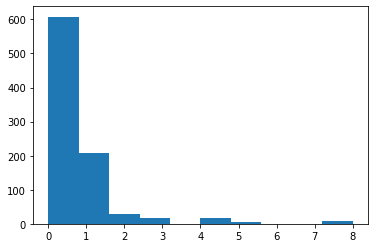

In [286]:
print(titanic_train["SibSp"].describe())
plt.hist(titanic_train["SibSp"])

count    418.000000
mean       0.447368
std        0.896760
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64


(array([283., 110.,  14.,   4.,   0.,   4.,   1.,   0.,   0.,   2.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

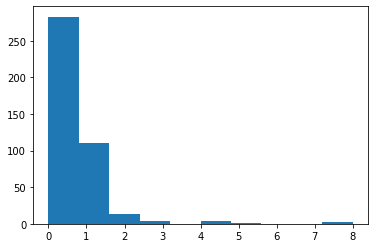

In [287]:
print(titanic_test["SibSp"].describe())
plt.hist(titanic_test["SibSp"])

In [288]:
def categorise_siblings(data):
    cut_labels_9 = ['sib_0','sib_1','sib_2','sib_3', 
                    'sib_4','sib_5','sib_6','sib_7', 'sib_8']
    cut_bins = [0,1,2,3,4,5,6,7,8,9]
    data['Sib_cat'] = pd.cut(data['SibSp'], 
                             bins=cut_bins, 
                             labels=cut_labels_9)
    
    data['Sib_cat'] = data.Sib_cat.astype(str)
    data.loc[data["Sib_cat"] == 'nan', "Sib_cat"] = "Sib_Unknown"
    
    return data

def transform_sibling_cat(data):
    factors = data['Sib_cat'].unique()
    gender_columns = pd.get_dummies(data['Sib_cat'])
    columns = range(0,len(factors))
    for column in columns:
        data[factors[column]] = gender_columns.loc[:, factors[column]].astype(float)
        
    return data

In [289]:
titanic_train = categorise_siblings(titanic_train)
titanic_train = transform_sibling_cat(titanic_train)
titanic_train = titanic_train.drop("SibSp", axis = 1)
titanic_train = titanic_train.drop("Sib_cat", axis = 1)
titanic_train.dtypes

PassengerId    float64
Pclass           int64
Sex             object
Age            float64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Survived         int64
sib_0          float64
Sib_Unknown    float64
sib_2          float64
sib_3          float64
sib_1          float64
sib_4          float64
sib_7          float64
dtype: object

In [290]:
titanic_train.shape

(891, 17)

In [291]:
titanic_test = categorise_siblings(titanic_test)
titanic_test = transform_sibling_cat(titanic_test)
titanic_test = titanic_test.drop("SibSp", axis = 1)
titanic_test = titanic_test.drop("Sib_cat", axis = 1)
titanic_test.dtypes

PassengerId    float64
Pclass           int64
Sex             object
Age            float64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Sib_Unknown    float64
sib_0          float64
sib_1          float64
sib_2          float64
sib_3          float64
sib_4          float64
sib_7          float64
dtype: object

In [292]:
titanic_test.shape

(418, 16)

# Transforming age into categories
The categorise the age into 9 categories; unknown and one for each decade. The categories are then transformed in hot_coding format. 

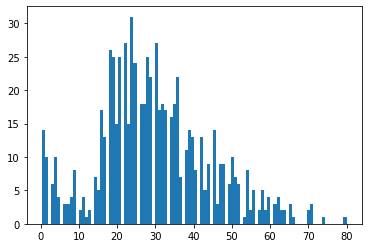

In [260]:
plt.hist(titanic_train['Age'], bins=100)
plt.show()

In [293]:
titanic_train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

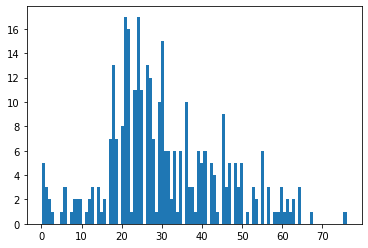

In [295]:
plt.hist(titanic_test['Age'], bins=100)
plt.show()

In [296]:
titanic_test['Age'].describe()

count    332.000000
mean      30.272590
std       14.181209
min        0.170000
25%       21.000000
50%       27.000000
75%       39.000000
max       76.000000
Name: Age, dtype: float64

In [297]:
def transform_age_cat(data):
    factors = data['Age_cat'].unique()
    gender_columns = pd.get_dummies(data['Age_cat'])
    columns = range(0,len(factors))
    for column in columns:
        data[factors[column]] = gender_columns.loc[:, factors[column]].astype(float)
        
    return data


In [298]:
def categorise_age(data):
    cut_labels_8 = ['age_0-9','age_10-19','age_20-29','age_30-39', 
                    'age_40-49','age_50-59','age_60-69','age_70-79']
    cut_bins = [0,10,20,30,40,50,60,70,80]
    data['Age_cat'] = pd.cut(data['Age'], 
                             bins=cut_bins, 
                             labels=cut_labels_8)
    data['Age_cat'] = data.Age_cat.astype(str)
    data.loc[data["Age"].isna(), "Age_cat"] = "Age_Unknown"
    return data

In [299]:
titanic_train = categorise_age(titanic_train)
titanic_train = transform_age_cat(titanic_train)
titanic_train = titanic_train.drop("Age", axis = 1)
titanic_train = titanic_train.drop("Age_cat", axis = 1)
titanic_train.dtypes

PassengerId    float64
Pclass           int64
Sex             object
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Survived         int64
sib_0          float64
Sib_Unknown    float64
sib_2          float64
sib_3          float64
sib_1          float64
sib_4          float64
sib_7          float64
age_20-29      float64
age_30-39      float64
Age_Unknown    float64
age_50-59      float64
age_0-9        float64
age_10-19      float64
age_60-69      float64
age_40-49      float64
age_70-79      float64
dtype: object

In [300]:
titanic_test = categorise_age(titanic_test)
titanic_test = transform_age_cat(titanic_test)
titanic_test = titanic_test.drop("Age", axis = 1)
titanic_test = titanic_test.drop("Age_cat", axis = 1)
titanic_test.dtypes

PassengerId    float64
Pclass           int64
Sex             object
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Sib_Unknown    float64
sib_0          float64
sib_1          float64
sib_2          float64
sib_3          float64
sib_4          float64
sib_7          float64
age_30-39      float64
age_40-49      float64
age_60-69      float64
age_20-29      float64
age_10-19      float64
Age_Unknown    float64
age_50-59      float64
age_0-9        float64
age_70-79      float64
dtype: object

## Gender transformation to hot-coding 
We check the factor values are the same between both datasets. Then, we generate a hot coding of two columns; i.e., male and female. Both columns replace the Sex column.

In [301]:
titanic_train['Sex'].unique()

array(['male', 'female'], dtype=object)

In [302]:
titanic_test['Sex'].unique()

array(['male', 'female'], dtype=object)

In [303]:
def transform_gender(data):
    factors = data['Sex'].unique()
    gender_columns = pd.get_dummies(data['Sex'])
    columns = range(0,len(factors))
    
    for column in columns:
        data[factors[column]] = gender_columns.loc[:,factors[column]].astype(float)
        
    return data
    

In [304]:
titanic_train = transform_gender(titanic_train)
titanic_train.drop("Sex", axis = 1, inplace = True)
titanic_train.dtypes

PassengerId    float64
Pclass           int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Survived         int64
sib_0          float64
Sib_Unknown    float64
sib_2          float64
sib_3          float64
sib_1          float64
sib_4          float64
sib_7          float64
age_20-29      float64
age_30-39      float64
Age_Unknown    float64
age_50-59      float64
age_0-9        float64
age_10-19      float64
age_60-69      float64
age_40-49      float64
age_70-79      float64
male           float64
female         float64
dtype: object

In [305]:
titanic_test = transform_gender(titanic_test)
titanic_test.drop("Sex", axis = 1,inplace = True)
titanic_test.head()

,PassengerId,Pclass,Parch,Ticket,Fare,Cabin,Embarked,Sib_Unknown,sib_0,sib_1,...,age_40-49,age_60-69,age_20-29,age_10-19,Age_Unknown,age_50-59,age_0-9,age_70-79,male,female
0,892.0,3,0,330911,7.8292,NaN,Q,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,893.0,3,0,363272,7.0000,NaN,S,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,894.0,2,0,240276,9.6875,NaN,Q,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,895.0,3,0,315154,8.6625,NaN,S,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,896.0,3,1,3101298,12.2875,NaN,S,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Cabin and Pclass

The passenger class appears to drive whether a cabin is known. So, we propose to drop the cabin as the percentage of not known values is quite high. We apply an hot encoding the Pclass. 

In [306]:
titanic_train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [307]:
print("percentage of cabin  nan values - training ", titanic_train['Cabin'].isna().sum()/titanic_train.shape[0])
print("percentage of cabin  nan values - test ", titanic_test['Cabin'].isna().sum()/titanic_test.shape[0])

percentage of cabin  nan values - training  0.7710437710437711
percentage of cabin  nan values - test  0.7822966507177034


In [308]:
titanic_train['Pclass'].unique()

array([3, 1, 2])

In [309]:
titanic_test['Pclass'].unique()

array([3, 2, 1])

In [310]:
titanic_train.loc[titanic_train['Pclass'] == 1 ,['Pclass','Cabin']]

,Pclass,Cabin
1,1,C85
3,1,C123
6,1,E46
11,1,C103
23,1,A6
...,...,...
871,1,D35
872,1,B51 B53 B55
879,1,C50
887,1,B42


In [311]:
titanic_train.loc[titanic_train['Pclass'] == 2 ,['Pclass','Cabin']]

,Pclass,Cabin
9,2,NaN
15,2,NaN
17,2,NaN
20,2,NaN
21,2,D56
...,...,...
866,2,NaN
874,2,NaN
880,2,NaN
883,2,NaN


In [312]:
titanic_train.loc[titanic_train['Pclass'] == 3 ,['Pclass','Cabin']]

,Pclass,Cabin
0,3,NaN
2,3,NaN
4,3,NaN
5,3,NaN
7,3,NaN
...,...,...
882,3,NaN
884,3,NaN
885,3,NaN
888,3,NaN


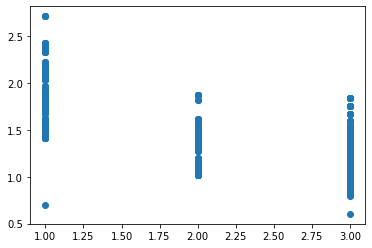

In [313]:
xs = titanic_train.loc[titanic_train['Fare'] > 0,'Pclass']
ys = np.log10(titanic_train.loc[titanic_train['Fare'] > 0,'Fare'])
plt.scatter(xs,ys)

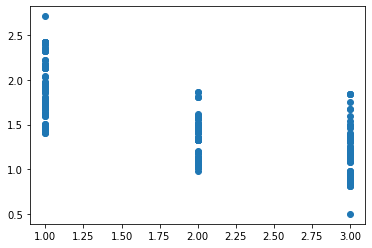

In [314]:
xs = titanic_test.loc[titanic_test['Fare'] > 0,'Pclass']
ys = np.log10(titanic_test.loc[titanic_test['Fare'] > 0,'Fare'])
plt.scatter(xs,ys)

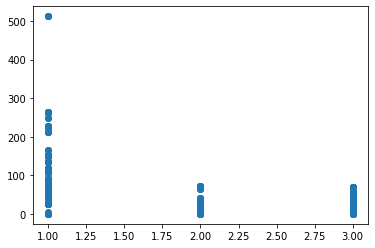

In [315]:
plt.scatter(titanic_train["Pclass"],titanic_train["Fare"])

In [316]:
def transform_Pclass(data):
    factors = data['Pclass'].unique()
    Pclass_columns = pd.get_dummies(data['Pclass'])
    columns = range(0,len(factors))
    
    for column in columns:
        col_name = 'Class_' + str(factors[column])
        data[col_name] = Pclass_columns.loc[:,factors[column]].astype(float)
        
    data.drop("Pclass", axis = 1)
    return data
    

In [317]:
titanic_train = transform_Pclass(titanic_train)
titanic_train.drop("Pclass", axis = 1, inplace = True)
titanic_train.drop("Cabin", axis = 1, inplace = True)
titanic_train.head()

,PassengerId,Parch,Ticket,Fare,Embarked,Survived,sib_0,Sib_Unknown,sib_2,sib_3,...,age_0-9,age_10-19,age_60-69,age_40-49,age_70-79,male,female,Class_3,Class_1,Class_2
0,1.0,0,A/5 21171,7.2500,S,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,2.0,0,PC 17599,71.2833,C,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,3.0,0,STON/O2. 3101282,7.9250,S,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,4.0,0,113803,53.1000,S,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,5.0,0,373450,8.0500,S,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [318]:
titanic_test = transform_Pclass(titanic_test)
titanic_test.drop("Pclass", axis = 1, inplace = True)
titanic_test.drop("Cabin", axis = 1, inplace = True)
titanic_test.head()

,PassengerId,Parch,Ticket,Fare,Embarked,Sib_Unknown,sib_0,sib_1,sib_2,sib_3,...,age_10-19,Age_Unknown,age_50-59,age_0-9,age_70-79,male,female,Class_3,Class_2,Class_1
0,892.0,0,330911,7.8292,Q,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,893.0,0,363272,7.0000,S,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,894.0,0,240276,9.6875,Q,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,895.0,0,315154,8.6625,S,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,896.0,1,3101298,12.2875,S,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


# Tickets and Fare
We remove the tickets, as it brings no additional characteristic for the prediction.

Old version: We reduce the complexity of the Fare by using the log.
New version: The price appears to be dependent on the class, so we drop the price.

In [319]:
titanic_train.drop("Ticket", axis = 1, inplace = True)
titanic_test.drop("Ticket", axis = 1, inplace = True)

In [320]:
log_10_values = np.log10(titanic_train.loc[titanic_train['Fare'] > 0,'Fare'])
titanic_train.loc[titanic_train['Fare'] > 0,'Fare'] = log_10_values
titanic_train.Fare.describe()


count    891.000000
mean       1.256781
std        0.435553
min        0.000000
25%        0.898198
50%        1.159994
75%        1.491362
max        2.709549
Name: Fare, dtype: float64

In [321]:
log_10_values = np.log10(titanic_test.loc[titanic_test['Fare'] > 0,'Fare'])
titanic_test.loc[titanic_test['Fare'] > 0,'Fare'] = log_10_values
titanic_test.Fare.describe()

count    417.000000
mean       1.279591
std        0.437507
min        0.000000
25%        0.897396
50%        1.159994
75%        1.498311
max        2.709549
Name: Fare, dtype: float64

In [322]:
titanic_train.drop("Fare", axis = 1, inplace = True)
titanic_test.drop("Fare", axis = 1, inplace = True)

# Embarked 
Embarked has three values "S", 'C', 'Q' and some values unknown. So, we replace the unknown values with U. A hot-encoding transforms the values into columns. 

The test datasets has no unknown values; so we had a column 'U' for consistency with hot-encoding. 


In [323]:
titanic_train.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [324]:
titanic_train.loc[titanic_train['Embarked'].isna(),'Embarked'] = 'U'
titanic_train.Embarked.unique()

array(['S', 'C', 'Q', 'U'], dtype=object)

In [325]:
titanic_test.loc[titanic_test['Embarked'].isna(),'Embarked'] = 'U'
titanic_test.Embarked.unique()

array(['Q', 'S', 'C'], dtype=object)

In [326]:
def transform_embarked(data):
    factors = data['Embarked'].unique()
    gender_columns = pd.get_dummies(data['Embarked'])
    columns = range(0,len(factors))
    
    for column in columns:
        data[factors[column]] = gender_columns.loc[:,factors[column]].astype(float)
        
    return data
    

In [327]:
titanic_train = transform_embarked(titanic_train)
titanic_train.drop("Embarked", axis = 1, inplace = True)
titanic_test  = transform_embarked(titanic_test)
titanic_test.drop("Embarked", axis = 1, inplace = True)


In [328]:
indices       = range(0, titanic_test.shape[0])
titanic_test['U'] = [0 for i in indices]
titanic_test['U'] = titanic_test['U'].astype(float)

# Outcome of data preparations

In [329]:

print("training datasets : " , titanic_train.shape)
titanic_train.dtypes

training datasets :  (891, 28)


PassengerId    float64
Parch            int64
Survived         int64
sib_0          float64
Sib_Unknown    float64
sib_2          float64
sib_3          float64
sib_1          float64
sib_4          float64
sib_7          float64
age_20-29      float64
age_30-39      float64
Age_Unknown    float64
age_50-59      float64
age_0-9        float64
age_10-19      float64
age_60-69      float64
age_40-49      float64
age_70-79      float64
male           float64
female         float64
Class_3        float64
Class_1        float64
Class_2        float64
S              float64
C              float64
Q              float64
U              float64
dtype: object

In [330]:
print("testing datasets : " , titanic_test.shape)
titanic_test.dtypes

testing datasets :  (418, 27)


PassengerId    float64
Parch            int64
Sib_Unknown    float64
sib_0          float64
sib_1          float64
sib_2          float64
sib_3          float64
sib_4          float64
sib_7          float64
age_30-39      float64
age_40-49      float64
age_60-69      float64
age_20-29      float64
age_10-19      float64
Age_Unknown    float64
age_50-59      float64
age_0-9        float64
age_70-79      float64
male           float64
female         float64
Class_3        float64
Class_2        float64
Class_1        float64
Q              float64
S              float64
C              float64
U              float64
dtype: object

In [331]:
train_cols = titanic_train.columns
test_cols = titanic_test.columns

common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)
train_not_test

Index(['Survived'], dtype='object')

In [332]:
titanic_test.columns

Index(['PassengerId', 'Parch', 'Sib_Unknown', 'sib_0', 'sib_1', 'sib_2',
       'sib_3', 'sib_4', 'sib_7', 'age_30-39', 'age_40-49', 'age_60-69',
       'age_20-29', 'age_10-19', 'Age_Unknown', 'age_50-59', 'age_0-9',
       'age_70-79', 'male', 'female', 'Class_3', 'Class_2', 'Class_1', 'Q',
       'S', 'C', 'U'],
      dtype='object')

# Cross validation preparation
We use a stratified sampling for the training into a train and test dataset. 

In [333]:
x_cols = ['Parch', 'Sib_Unknown', 'sib_0', 'sib_1', 'sib_2', 'sib_3', 'sib_4', 'sib_7', 'age_30-39', 'age_40-49', 'age_60-69', 'age_20-29', 'age_10-19', 'Age_Unknown', 'age_50-59',
       'age_0-9', 'age_70-79', 'male', 'female', 'Class_3', 'Class_2',
       'Class_1', 'Q', 'S', 'C', 'U']
y_col = 'Survived'
X = titanic_train.copy(deep = True)
X = X[x_cols]
X = X.apply(pd.to_numeric)
y = titanic_train[y_col].apply(pd.to_numeric)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid  = X.iloc[test_valid_index]
    y_valid  = y.iloc[test_valid_index]

# we see our training set follows the same distribution
print(y_train.value_counts(normalize=True), '\n\n')

# we see our test set follows the same distribution
print(y_valid.value_counts(normalize=True))

0    0.616105
1    0.383895
Name: Survived, dtype: float64 


0    0.616246
1    0.383754
Name: Survived, dtype: float64


In [336]:
X_train.shape

(534, 26)

In [339]:
X_valid.shape

(357, 26)

In [340]:
y_train_encode=pd.get_dummies(y_train)
y_valid_encode=pd.get_dummies(y_valid)


In [341]:
train_cols = X_train.columns
test_cols = titanic_test.columns

common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)
train_not_test

Index([], dtype='object')

## ANN

We apply an ANN to predict the survival of passengers.  We create a basic architecture made of 5 layers.

In [342]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

tf.compat.v1.get_default_graph()

no_columns = X_train.shape[1]
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(no_columns,)))
model.add(tf.keras.layers.Dense(32, activation="sigmoid"))
model.add(tf.keras.layers.Dense(32, activation="sigmoid"))
model.add(tf.keras.layers.Dense(32, activation="sigmoid"))
model.add(tf.keras.layers.Dense(2, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 26)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                864       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 3,042
Trainable params: 3,042
Non-trainable params: 0
_________________________________________________________________


2022-12-22 16:11:24.449094: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [344]:

rate = 0.00021
opt = tf.keras.optimizers.Adam(learning_rate = rate)
model.compile(optimizer= opt, 
                  loss = "binary_crossentropy",
                  metrics=["accuracy"])
tf.compat.v1.get_default_graph()
history = model.fit(X_train,
                        y_train_encode,
                        validation_data=(X_valid, y_valid_encode),
                        epochs = 300,
                        verbose = False)


2022-12-22 16:12:10.828099: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [345]:
_, accuracy = model.evaluate(X_valid, y_valid_encode)
print('Accuracy: %.4f' % (accuracy*100))

12/12 [==============================] - 0s 2ms/step - loss: 0.4279 - accuracy: 0.8123
Accuracy: 81.2325


### Which passengers were misclassified 

In [346]:

y_pred = model.predict(X_valid)
Y_pred = np.argmax(model.predict(X_valid),axis=1)
cm = confusion_matrix(y_valid, Y_pred)
cm

array([[204,  16],
       [ 51,  86]])

In [347]:
accuracy          = (cm[0][0] + cm[1][1])/len(y_pred)
misclassification = (cm[0][1] + cm[1][0])/len(y_pred)
sensitivity       = (cm[0][0])/(cm[0][0] + cm[0][1])
specificity       = (cm[1][1])/(cm[1][0] + cm[1][1])
print("Accuracy         : ", accuracy)
print("Misclassfication : ", misclassification)
print("Sensitivivity    : ", sensitivity)
print("Specificity      : ", specificity)


Accuracy         :  0.8123249299719888
Misclassfication :  0.1876750700280112
Sensitivivity    :  0.9272727272727272
Specificity      :  0.6277372262773723


Overall, the number of survivors misclassified were greater than misclassified passengers who perished. The next step is to identify those passengers to attempt to find the source of the misclassifcation. So far the lowest number  of misclassified passengers who  perished. 

In [357]:
errors_pd = X_valid.copy(deep=True)
errors_pd["Y_true"] = y_valid
errors_pd["Y_pred"] = y_pred.argmax(1)
errors_pd = errors_pd.loc[errors_pd["Y_true"] !=  errors_pd["Y_pred"],]
errors_pd

,Parch,Sib_Unknown,sib_0,sib_1,sib_2,sib_3,sib_4,sib_7,age_30-39,age_40-49,...,female,Class_3,Class_2,Class_1,Q,S,C,U,Y_true,Y_pred
541,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1
583,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1
279,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0
607,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0
804,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0
455,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0
347,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0
297,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,1


In [358]:
errors_pd.describe()

,Parch,Sib_Unknown,sib_0,sib_1,sib_2,sib_3,sib_4,sib_7,age_30-39,age_40-49,...,female,Class_3,Class_2,Class_1,Q,S,C,U,Y_true,Y_pred
count,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.0,67.0,67.000000,67.000000,...,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.0,67.000000,67.000000
mean,0.522388,0.582090,0.313433,0.029851,0.029851,0.044776,0.0,0.0,0.194030,0.074627,...,0.388060,0.641791,0.059701,0.298507,0.059701,0.776119,0.164179,0.0,0.761194,0.238806
std,0.943209,0.496938,0.467390,0.171460,0.171460,0.208373,0.0,0.0,0.398437,0.264772,...,0.490986,0.483093,0.238721,0.461057,0.238721,0.419989,0.373234,0.0,0.429572,0.429572
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.000000
max,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


In [360]:
errors_pd.loc[errors_pd["Class_1"] == 1.0]

,Parch,Sib_Unknown,sib_0,sib_1,sib_2,sib_3,sib_4,sib_7,age_30-39,age_40-49,...,female,Class_3,Class_2,Class_1,Q,S,C,U,Y_true,Y_pred
583,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1
607,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0
802,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0
647,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0
681,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0
55,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0
701,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0
390,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0
572,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0
430,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0


In [361]:
errors_pd.loc[errors_pd["Class_2"] == 1.0]

,Parch,Sib_Unknown,sib_0,sib_1,sib_2,sib_3,sib_4,sib_7,age_30-39,age_40-49,...,female,Class_3,Class_2,Class_1,Q,S,C,U,Y_true,Y_pred
17,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,0
199,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,1
570,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,0
226,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,0


In [362]:
errors_pd.loc[errors_pd["Class_3"] == 1.0]

,Parch,Sib_Unknown,sib_0,sib_1,sib_2,sib_3,sib_4,sib_7,age_30-39,age_40-49,...,female,Class_3,Class_2,Class_1,Q,S,C,U,Y_true,Y_pred
541,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1
279,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0
804,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0
813,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1
429,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0
501,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
315,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0
205,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1
419,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1
642,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1


The passenger class  and being  male can lead  to errors. However, the number of female passengers increases as the class lower.

In [366]:
x_cols = ['Parch', 'Sib_Unknown', 'sib_0', 'sib_1', 'sib_2', 'sib_3', 'sib_4', 'sib_7', 'age_30-39', 'age_40-49', 'age_60-69', 'age_20-29', 'age_10-19', 'Age_Unknown', 'age_50-59',
       'age_0-9', 'age_70-79', 'male', 'female', 'Class_3', 'Class_2',
       'Class_1', 'Q', 'S', 'C', 'U']
X_test = titanic_test[x_cols]

In [369]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(1)
ann    = pd.DataFrame({"PassengerId": titanic_test["PassengerId"],
                       "Survived" : y_pred})
ann

,PassengerId,Survived
0,892.0,0
1,893.0,0
2,894.0,0
3,895.0,0
4,896.0,0
...,...,...
413,1305.0,0
414,1306.0,1
415,1307.0,0
416,1308.0,0


# Submission

In [ ]:
submission = pd.DataFrame({
        "PassengerId": X_test["PassengerId"],
        "Survived": Y_pred
    })
# submission.to_csv('../output/submission.csv', index=False)
